# Algorithmic trading based on Technical Analysis in Python

## Introduction

This is the fourth part of a series of articles on backtesting trading strategies in Python. The previous ones described the following topics:
* introducing the zipline framework and presenting how to test basic strategies (link)
* importing custom data to use with zipline (link)
* evaluating the performance of trading strategies (link)

This time, the goal of the article is to show how to create trading strategies based on Technical Analysis (TA in short). Quoting Wikipedia, technical analysis is a "methodology for forecasting the direction of prices through the study of past market data, primarily price, and volume". 

In this article I show how to use a popular Python library for calculating TA indicators - `TA-Lib` - together with the `zipline` backtesting framework. I will create 5 strategies and see which one performs best over the same investment horizon.

## Importing Libraries

Below I import all the required libraries:

In [9]:
%load_ext watermark

In [8]:
%load_ext zipline

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Then we import the rest of the libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials
from datetime import datetime
from dateutil.relativedelta import relativedelta

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install yahoofinancials

     |████████████████████████████████| 106 kB 13.3 MB/s eta 0:00:01
  Created wheel for yahoofinancials: filename=yahoofinancials-1.5-py3-none-any.whl size=15199 sha256=c16f71de7cdd5fd83e0af1c74ee606efe0d9be45955d731985d63ebffeded176
  Stored in directory: /home/abeo/.cache/pip/wheels/77/ac/c9/d331d94fb981076ba43caa82f57fccc634d2131004363bd99b
Successfully built yahoofinancials


Below you can see the list of libraries used in this article, together with their versions.

In [5]:
%watermark --iversions

pyfolio    0.9.2
matplotlib 3.0.0
empyrical  0.5.0
json       2.0.9
numpy      1.14.6
pandas     0.22.0
zipline    1.3.0



## Helper Functions

Before creating the strategies, I define a few helper functions. 

The first one is used for getting the modified start date of the backtest. What I mean by this is that I would like all strategies to start working on the same day - the first day of 2016. However, some strategies based on technical indicators require a certain number of past observations - the so called "warm-up period". That is why using this function I calculate the date the backtest should start so that on the first day of the investment horizon I already have enough past observations to calculate the indicators. Please bear in mind that no trading decision can happen before the true start date of the backtest!

In [5]:
def get_start_date(ticker, start_date, days_prior):
    '''
    Calculate the modified starting of the pbacktest to account for the warm-up period.
    
    Parameters
    ------------
    ticker : str
        Ticker of the asset we want to use in the backtest
    start_date : str
        The start date we want to modify
    days_prior : int
        The required number of trading days prior to the first day of the backtest

    Returns
    -----------
    new_start_date : str
        The adjusted starting date for the backtest
    '''
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    prior_to_start_date_dt = start_date_dt - relativedelta(days=2*days_prior)
    prior_to_start_date = prior_to_start_date_dt.strftime('%Y-%m-%d')
    
    yahoo_financials = YahooFinancials(ticker)
    
    df = yahoo_financials.get_historical_price_data(prior_to_start_date, start_date, 'daily')
    df = pd.DataFrame(df[ticker]['prices'])['formatted_date']
    if df.iloc[-1] == start_date:
        days_prior += 1 
    
    new_start_date = df.iloc[-days_prior]
    
    return new_start_date

In [7]:
def get_performance_summary(returns):
    '''
    Calculate selected performance evaluation metrics using provided returns.
    
    Parameters
    ------------
    returns : pd.Series
        Series of returns we want to evaluate

    Returns
    -----------
    stats : pd.Series
        The calculated performance metrics
        
    '''
    stats = {'annualized_returns': ep.annual_return(returns),
             'cumulative_returns': ep.cum_returns_final(returns),
             'annual_volatility': ep.annual_volatility(returns),
             'sharpe_ratio': ep.sharpe_ratio(returns),
             'sortino_ratio': ep.sortino_ratio(returns),
             'max_drawdown': ep.max_drawdown(returns)}
    return pd.Series(stats)

In [6]:
def visualize_results(df, title):
    '''
    Visualize the overview of the trading strategy including:
    * the evolution of the capital
    * price of the asset, together with buy/sell signals
    * daily returns
    
    Parameters
    ------------
    df : pd.DataFrame
        Performance DataFrame obtained from `zipline`
    title : str
        The title of the plot
        
    '''
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

    # portfolio value
    df.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')

    # asset
    df.price.plot(ax=ax[1])
    ax[1].set_ylabel('price in $')

    # mark transactions
    perf_trans = df.loc[[t != [] for t in df.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, df.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, df.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')

    # daily returns
    df.returns.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

    print('Final portfolio value (including cash): {}$'.format(np.round(df.portfolio_value[-1], 2)))

## Strategies

In this article we use the following problem setting:
* the investor has a capital of 10000$
* the investment horizon covers years 2016-2017
* the investor can only invest in Tesla's stock
* we assume no transactions costs - zero-commission trading
* there is no short selling (the investor can only sell what he/she currently owns)
* when the investor opens a position (buys the stock), the investor goes "all in" - allocates all available resources for the purchase

One of the reasons for selecting this range of dates is the fact that from mid 2018 the Quandl dataset was not updated and we want to keep the code as simple as possible. For details on how to load custom data (including the latest stock prices) into `zipline`, please refer to my previous article (link).

### Buy And Hold Strategy

We start with the most basic strategy - Buy and Hold. The idea is that we buy a certain asset and do not do anything for the entire duration of the investment horizon. So at the first possible date, we buy as much Tesla stock as we can with our capital and do nothing later. 

This simple strategy can also be considered a benchmark for more advanced ones - because there is no point in using a very complex strategy that generates less money (in general or due to transaction costs) than buying once and doing nothing.

In [11]:
%%zipline --start 2016-1-1 --end 2017-12-31 --capital-base 10000.0 -o buy_and_hold.pkl

# imports
from zipline.api import order_percent, symbol, record
from zipline.finance import commission

# parameters
SELECTED_STOCK = 'TSLA'

def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.has_ordered = False  
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))

def handle_data(context, data):
    
    # trading logic
    if not context.has_ordered:
        order_percent(context.asset, 1)
        context.has_ordered = True
        
    record(price=data.current(context.asset, 'price'))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

We load the performance DataFrame:

In [10]:
buy_and_hold_results = pd.read_pickle('buy_and_hold.pkl')

What can happen here (it did not, but it is good to be aware of) is the sudden appearance of negative `ending_cash`. The reason for that could be the fact that the amount of shares we want to buy is calculated at the end of the day, using that day's (closing) price. However, the order is executed on the next day, and the price can change significantly. In `zipline` the order is not rejected due to insufficient funds, but we can end up with a negative balance. This can happen mostly with strategies that go "all-in". We could come up with some ways to avoid it - for example manually calculating the number of shares we can buy the next day and also including some markup to prevent such a situation from occurring, however, for simplicity we accept that this can happen.

We use a helper function to visualize some details of the strategy: the evolution of the portfolio's value, the transactions on top of the price series, and the daily returns.

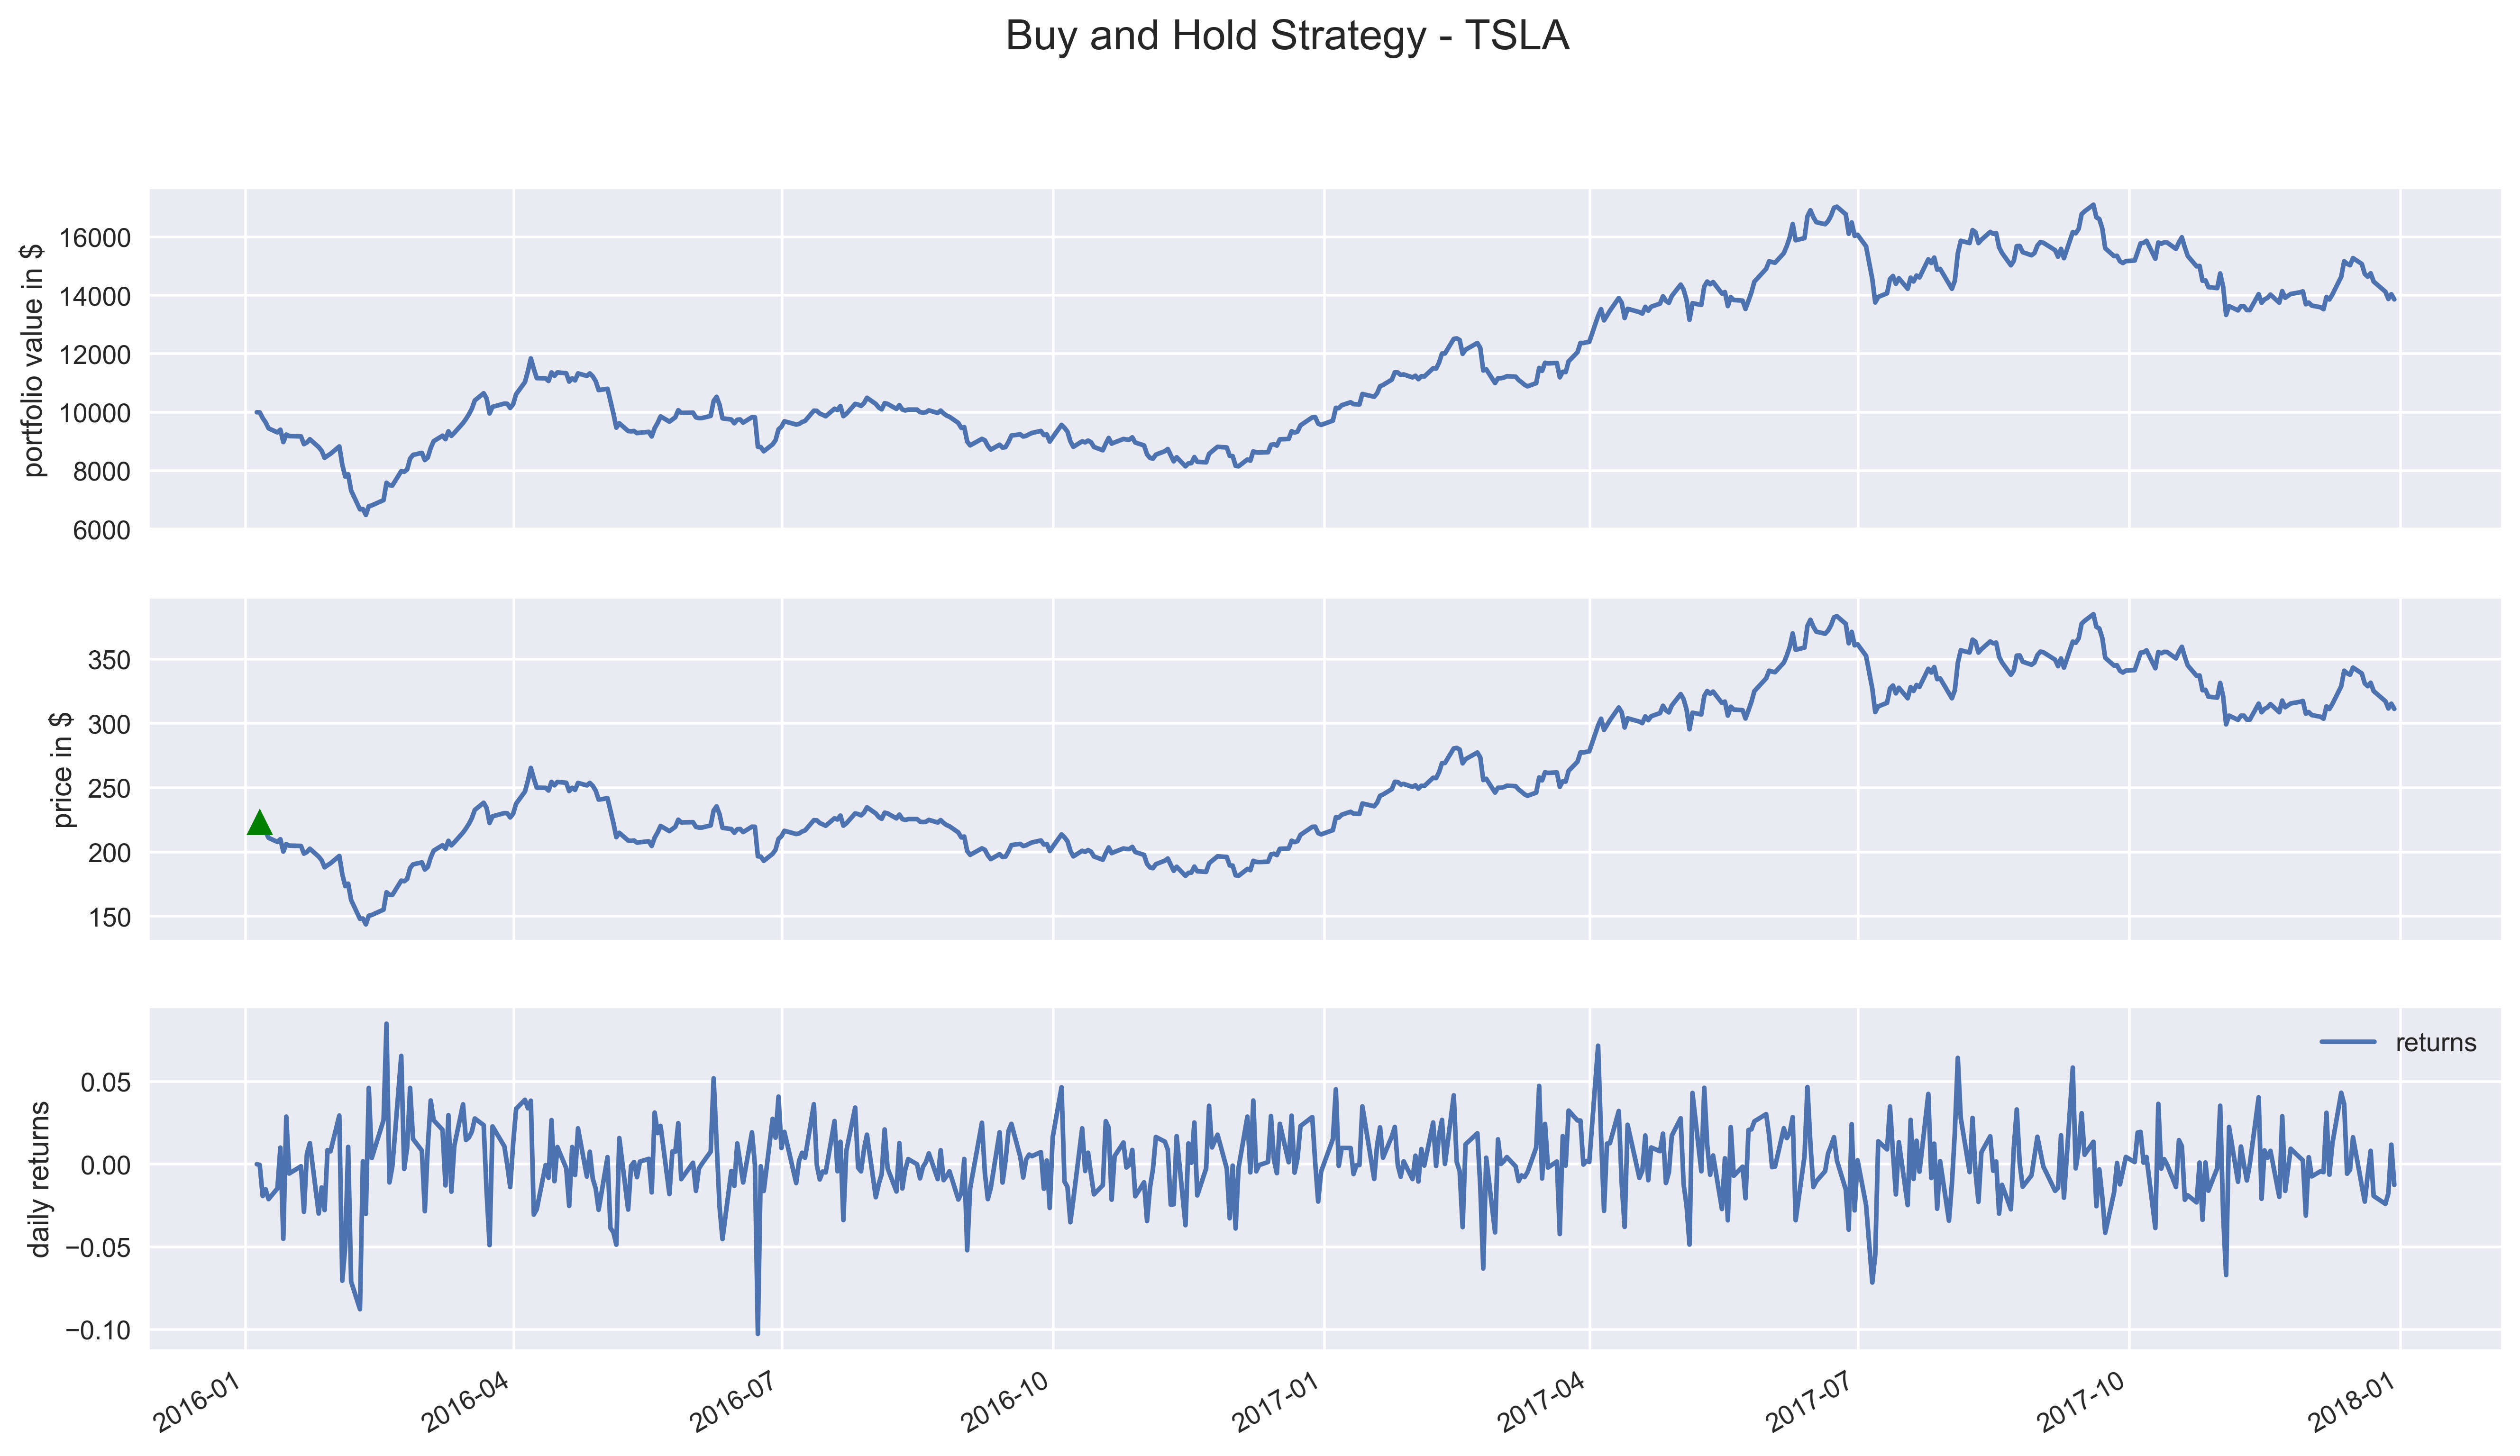

Final portfolio value (including cash): 13863.56$


In [11]:
visualize_results(buy_and_hold_results, 'Buy and Hold Strategy - TSLA')

In [13]:
# possible additional summary statistics
# pf.create_simple_tear_sheet(buy_and_hold_results.returns)

We also create the performance summary (using another helper function), which will be used in the last section:

In [14]:
buy_and_hold_perf = get_performance_summary(buy_and_hold_results.returns)

### Simple Moving Average Strategy

The second strategy we consider is based on the simple moving average (SMA). The logic of the strategy can be summarized by the following:

* when the price crosses the 20-day SMA upwards - buy shares
* when the price crosses the 20-day SMA downwards - sell all the shares
* the moving average uses 19 prior days and the current day - trading decision is for the next day

This is the first time we need to use the previously defined helper function to calculate the adjusted starting date, which will enable the investor to make trading decisions on the first trading day of 2016.

In [15]:
get_start_date('TSLA', '2016-01-04', 19)

'2015-12-04'

In the strategy below, we use the adjusted date as the start date.

Note: `data.current(context.asset, 'price')` is equivalent to `price_history[-1]`

In [16]:
%%zipline --start 2015-12-4 --end 2017-12-31 --capital-base 10000.0 -o simple_moving_average.pkl

# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
MA_PERIODS = 20
SELECTED_STOCK = 'TSLA'

def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False

def handle_data(context, data):
    context.time += 1
    record(time=context.time)
    if context.time < MA_PERIODS:
        return

    price_history = data.history(context.asset, fields="price", bar_count=MA_PERIODS, frequency="1d")
    ma = price_history.mean()
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           moving_average=ma)

/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


algo_volatility  algorithm_period_return     alpha  \
2015-12-04 21:00:00+00:00              NaN                 0.000000       NaN   
2015-12-07 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-08 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-09 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-10 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-11 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-14 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-15 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-16 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-17 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-18 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-21 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-22 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-23 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-24 18:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-28 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-29 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-30 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-31 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-04 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-05 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-06 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-07 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-08 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-11 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-12 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-13 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-14 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-15 21:00:00+00:00         0.000000                 0.000000  0.000000   
2016-01-19 21:00:00+00:00         0.000000                 0.000000  0.000000   
...                                    ...                      ...       ...   
2017-11-16 21:00:00+00:00         0.239012                 0.662822  0.253551   
2017-11-17 21:00:00+00:00         0.238771                 0.662822  0.253459   
2017-11-20 21:00:00+00:00         0.238531                 0.662822  0.252710   
2017-11-21 21:00:00+00:00         0.238291                 0.662822  0.251349   
2017-11-22 21:00:00+00:00         0.238054                 0.662010  0.250714   
2017-11-24 18:00:00+00:00         0.237884                 0.677350  0.254479   
2017-11-27 21:00:00+00:00         0.237653                 0.683902  0.256029   
2017-11-28 21:00:00+00:00         0.237416                 0.687750  0.255304   
2017-11-29 21:00:00+00:00         0.238262                 0.635698  0.239178   
2017-11-30 21:00:00+00:00         0.238031                 0.641707  0.239287   
2017-12-01 21:00:00+00:00         0.237795                 0.641707  0.239102   
2017-12-04 21:00:00+00:00         0.237560                 0.641707  0.238793   
2017-12-05 21:00:00+00:00         0.237325                 0.641707  0.238832   
2017-12-06 21:00:00+00:00         0.237091                 0.641707  0.238331   
2017-12-07 21:00:00+00:00         0.236860                 0.640897  0.237204   
2017-12-08 21:00:00+00:00         0.236758                 0.661125  0.241820   
2017-12-11 21:00:00+00:00         0.238367                 0.732781  0.261709   
2017-12-12 21:00:00+00:00         0.239413                

In [17]:
sma_results = pd.read_pickle('simple_moving_average.pkl')

We verify that on the first day of 2016 we have 20 observations necessary for the moving average.

In [18]:
sma_results.time.head(25)

2015-12-04 21:00:00+00:00     1
2015-12-07 21:00:00+00:00     2
2015-12-08 21:00:00+00:00     3
2015-12-09 21:00:00+00:00     4
2015-12-10 21:00:00+00:00     5
2015-12-11 21:00:00+00:00     6
2015-12-14 21:00:00+00:00     7
2015-12-15 21:00:00+00:00     8
2015-12-16 21:00:00+00:00     9
2015-12-17 21:00:00+00:00    10
2015-12-18 21:00:00+00:00    11
2015-12-21 21:00:00+00:00    12
2015-12-22 21:00:00+00:00    13
2015-12-23 21:00:00+00:00    14
2015-12-24 18:00:00+00:00    15
2015-12-28 21:00:00+00:00    16
2015-12-29 21:00:00+00:00    17
2015-12-30 21:00:00+00:00    18
2015-12-31 21:00:00+00:00    19
2016-01-04 21:00:00+00:00    20
2016-01-05 21:00:00+00:00    21
2016-01-06 21:00:00+00:00    22
2016-01-07 21:00:00+00:00    23
2016-01-08 21:00:00+00:00    24
2016-01-11 21:00:00+00:00    25
Name: time, dtype: int64

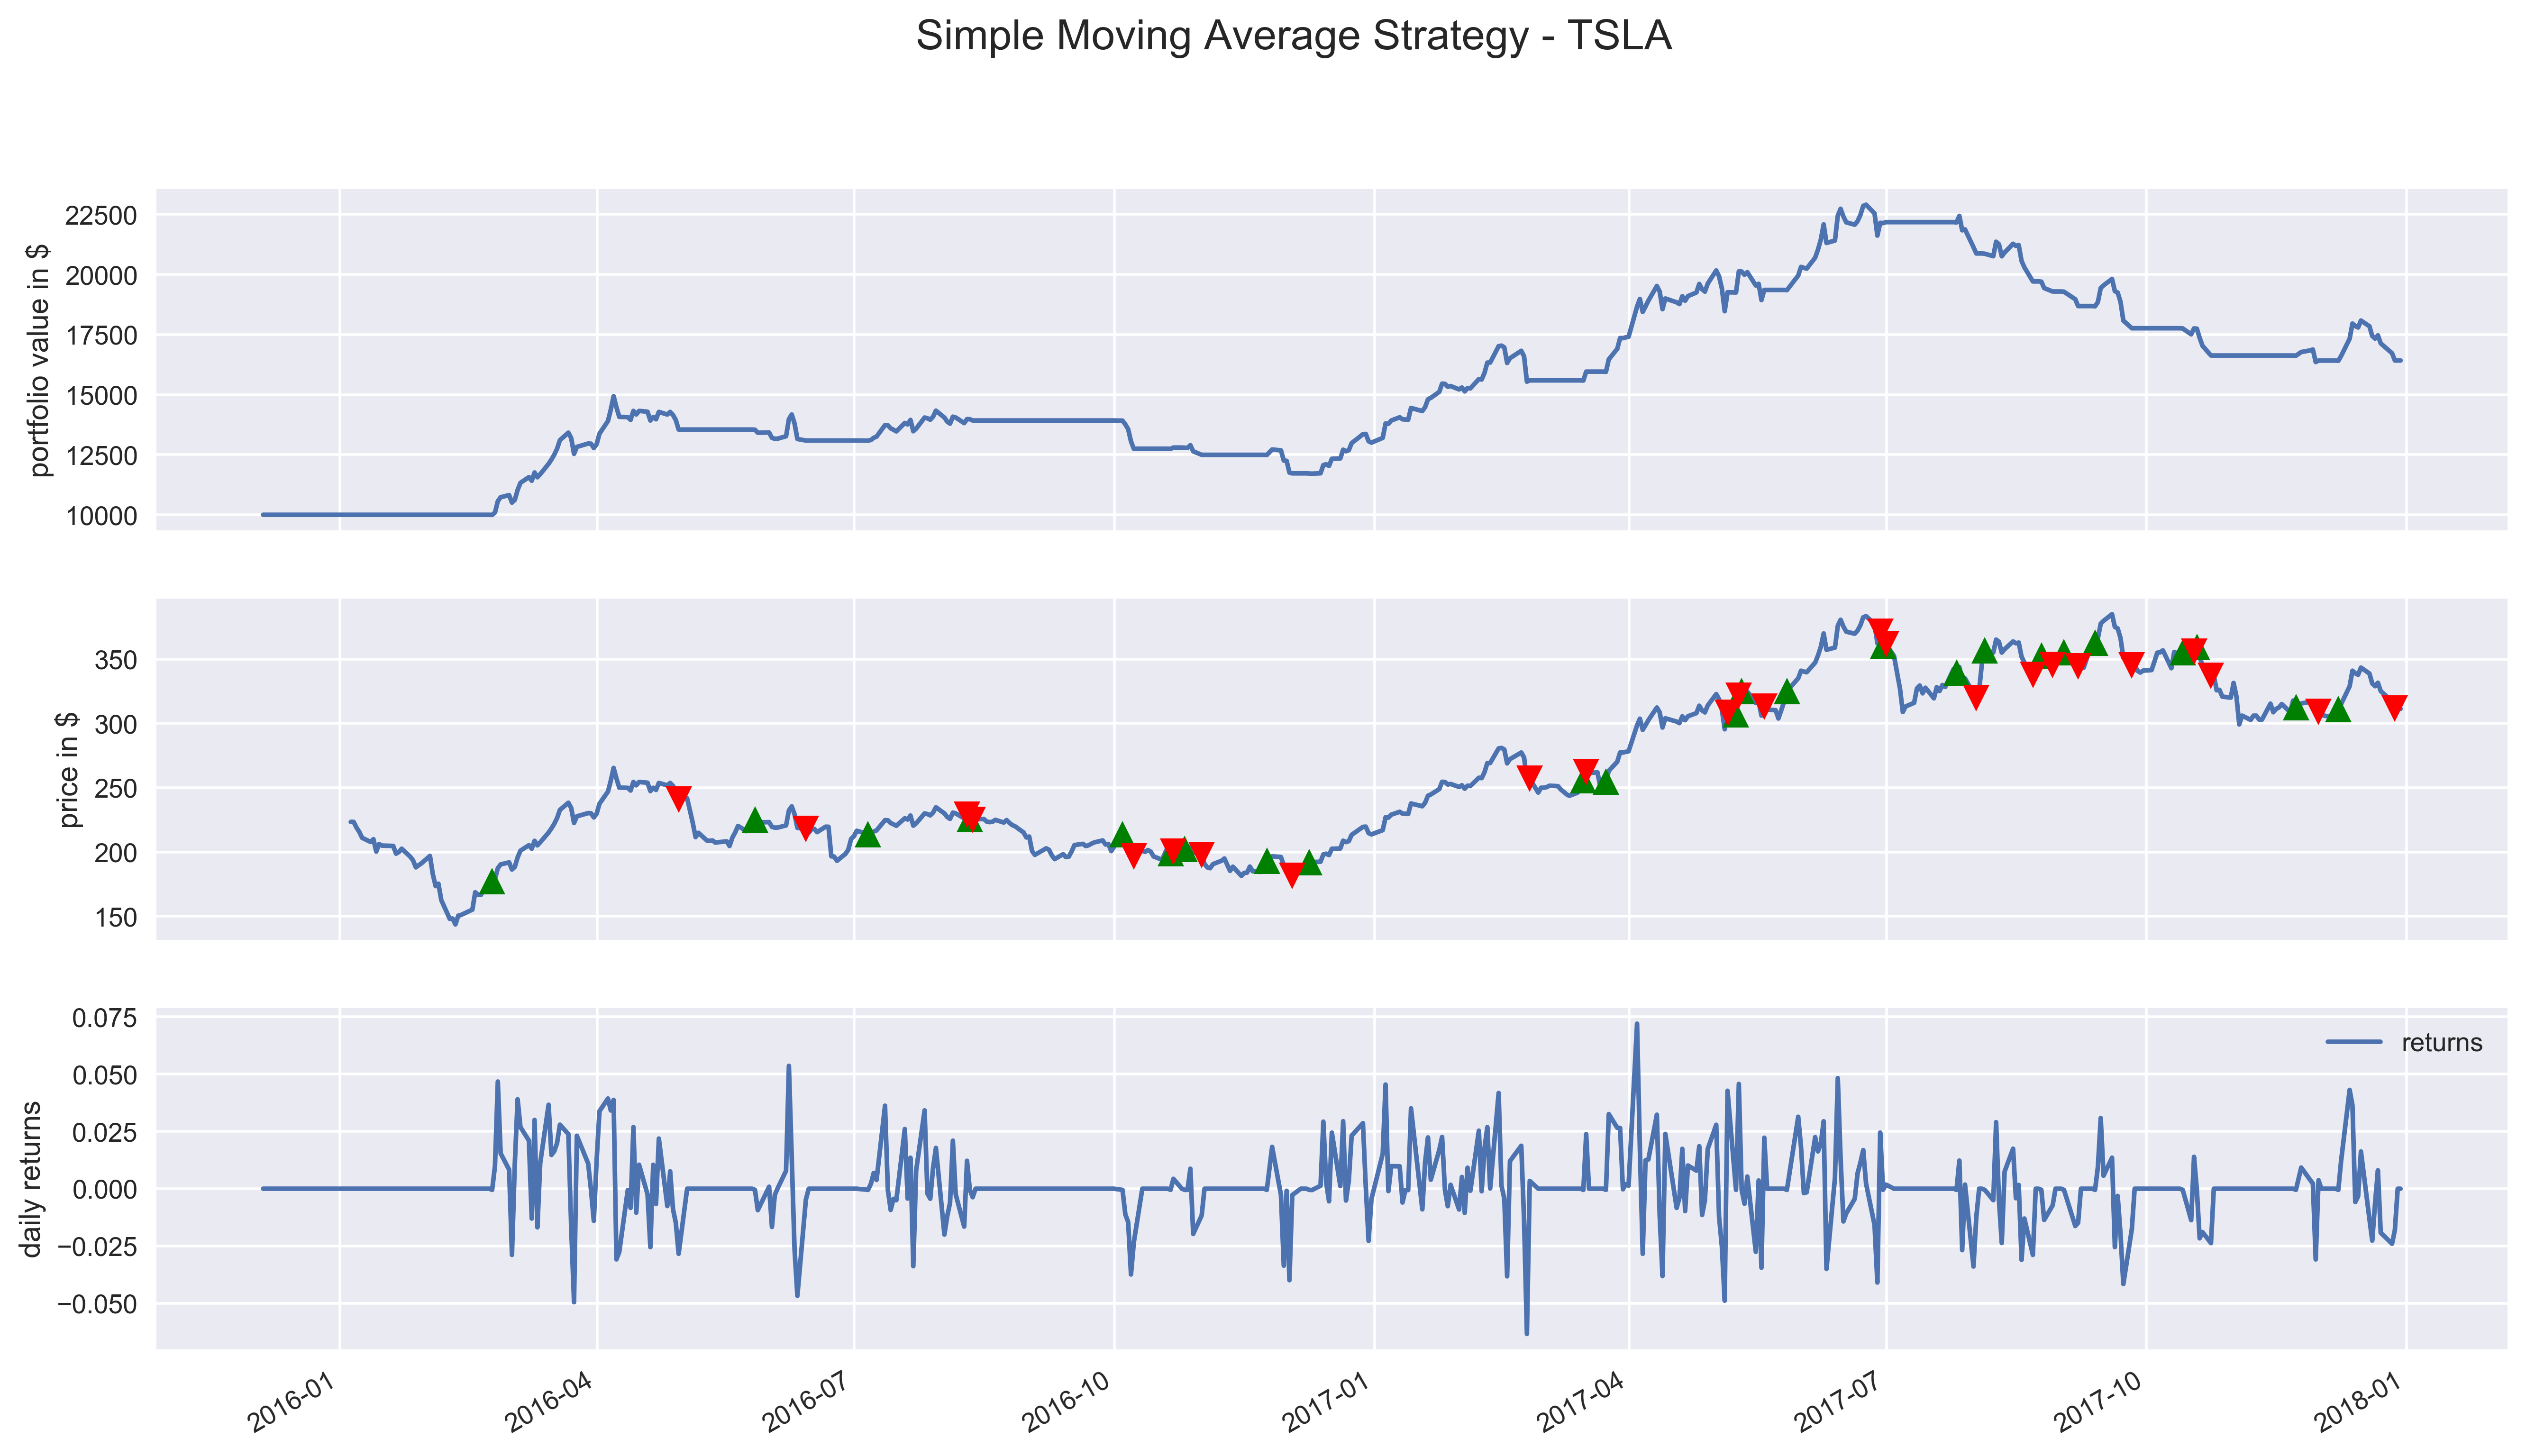

Final portfolio value (including cash): 16421.67$


In [19]:
visualize_results(sma_results, 'Simple Moving Average Strategy - TSLA')

The plot below shows the price series together with the 20-day moving average. We have additionally marked the orders, which are executed on the next trading day after the signal was generated.

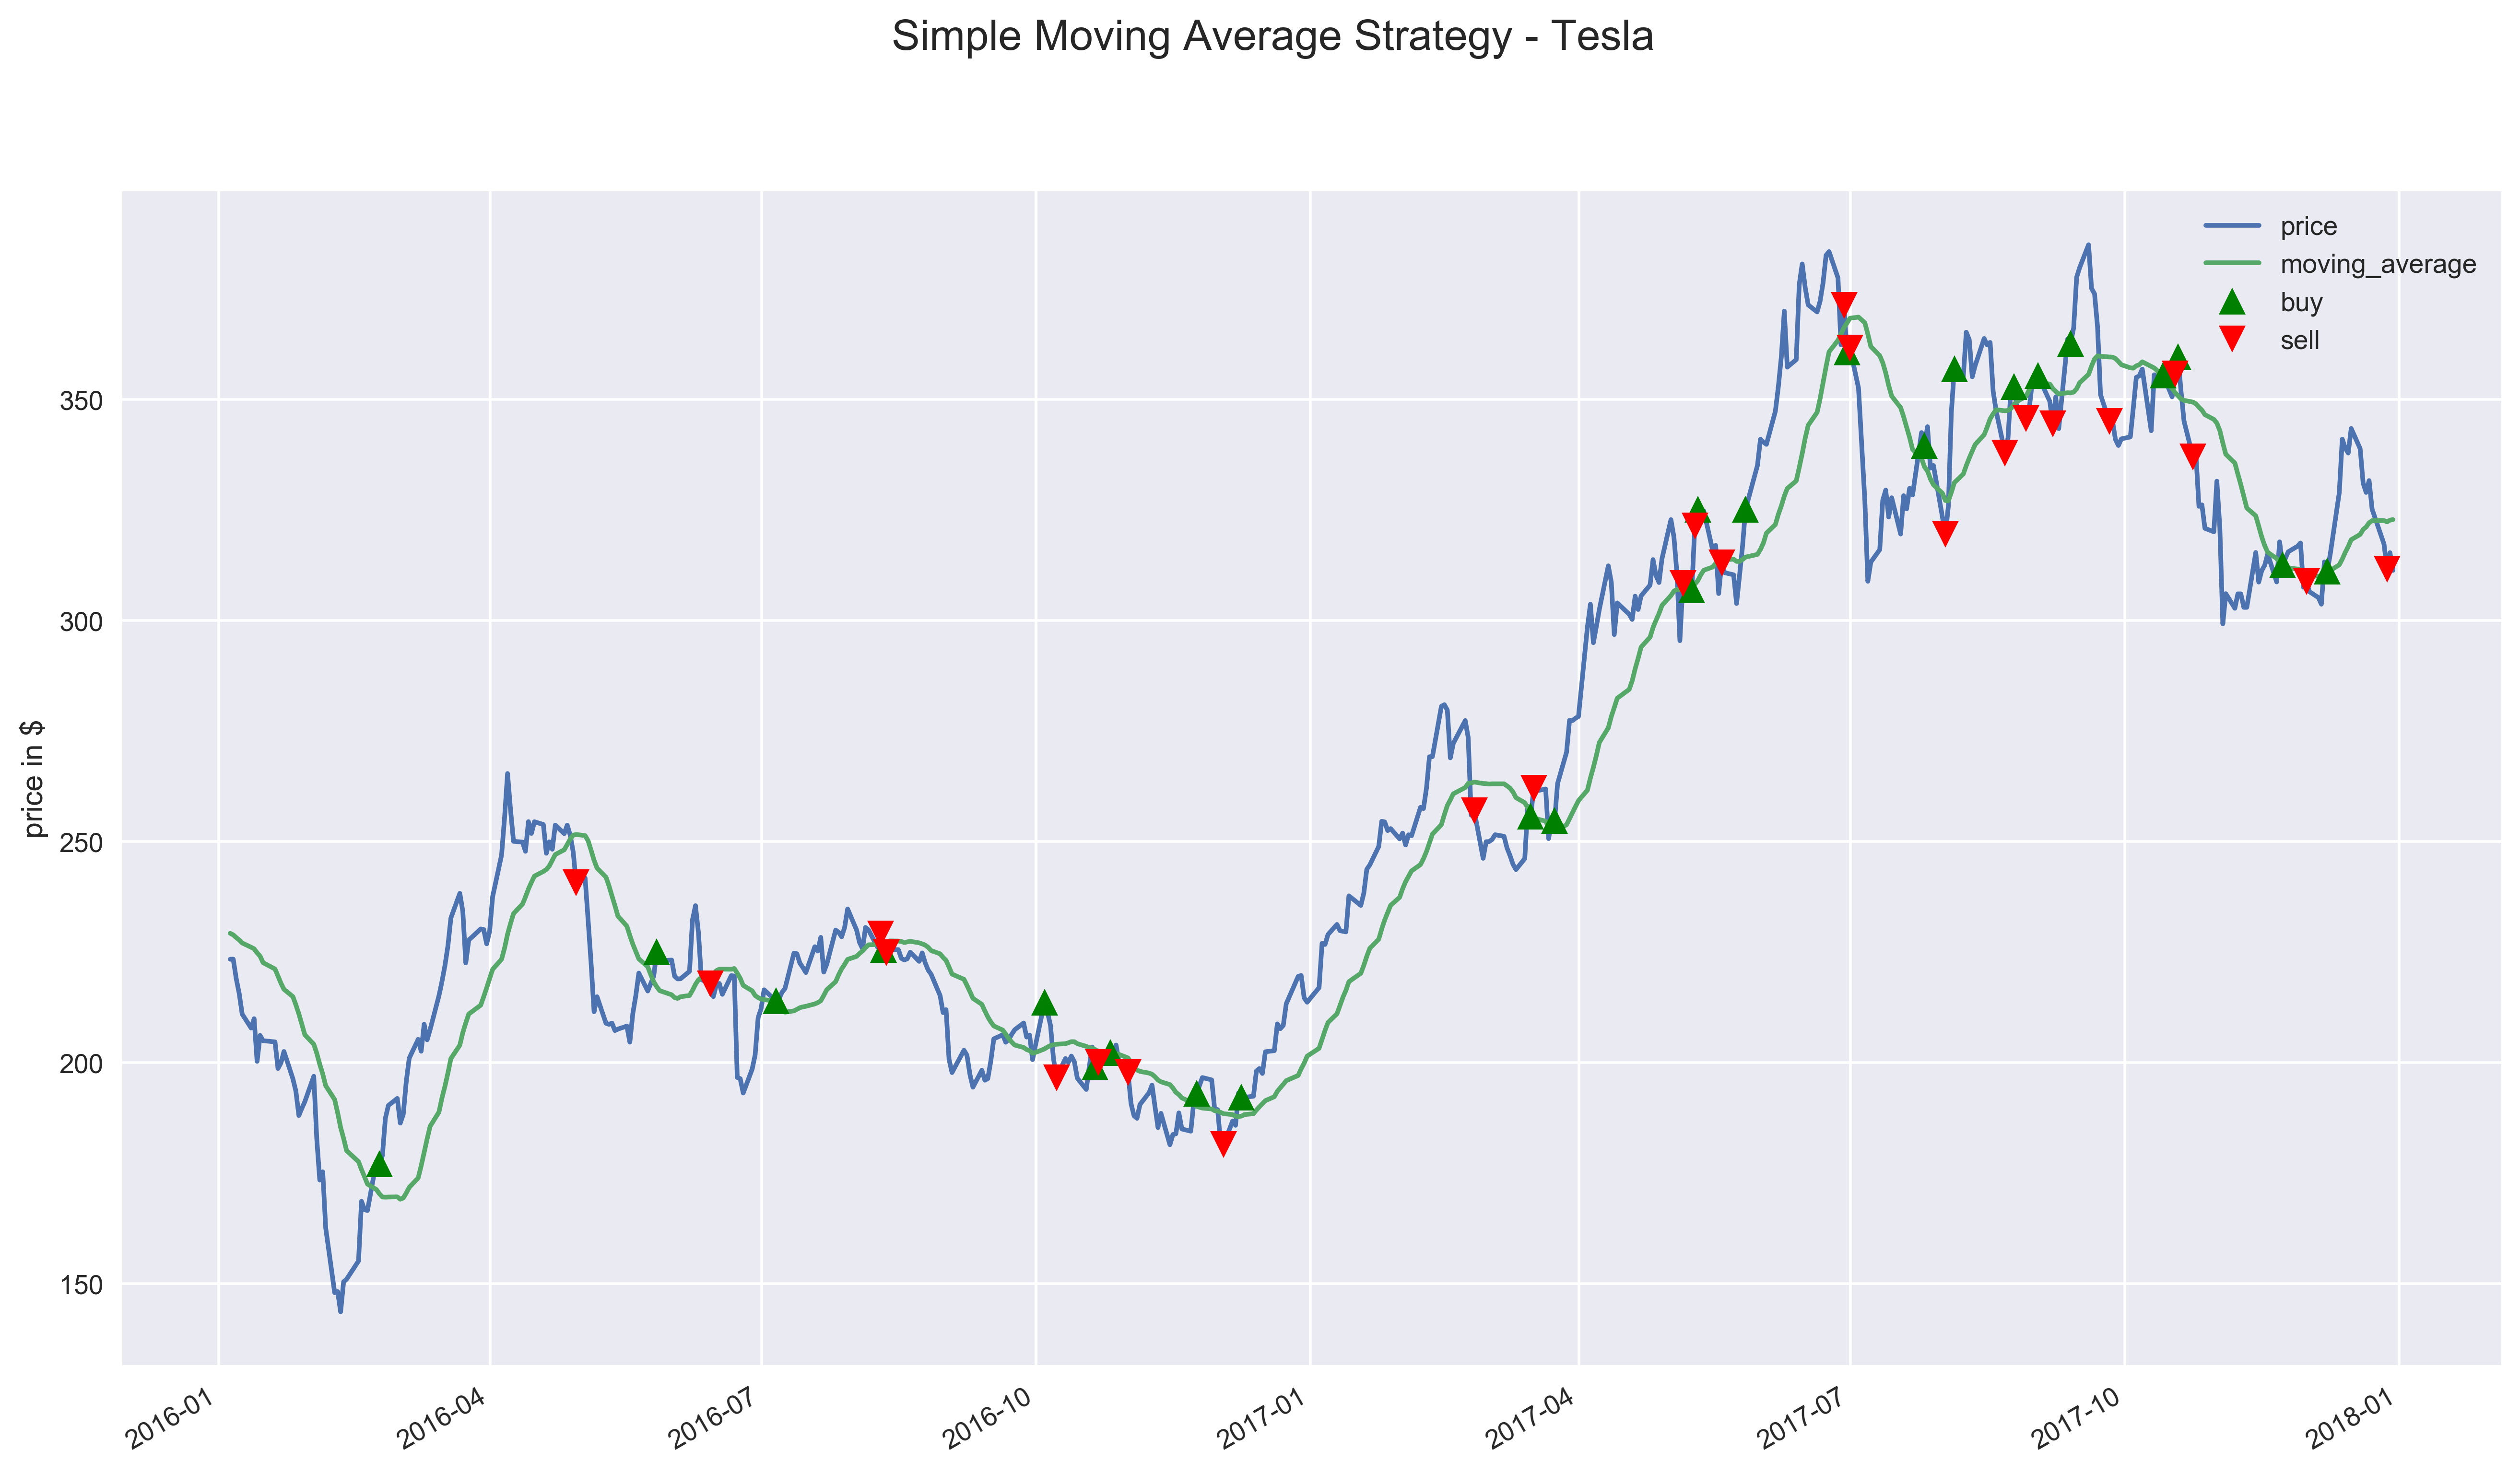

In [20]:
fig, ax = plt.subplots()

# asset
sma_results[['price', 'moving_average']].plot(ax=ax)
ax.set_ylabel('price in $')

# mark transactions
perf_trans = sma_results.loc[[t != [] for t in sma_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, sma_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, sma_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('Simple Moving Average Strategy - TSLA', fontsize=16)
plt.legend()
plt.show()

For calculating the returns and performance metrics, we discard the data prior to the start of the backtest.

In [21]:
sma_returns = sma_results.loc[sma_results.index >= '2016-01-04', 'returns']

In [22]:
sma_perf = get_performance_summary(sma_returns)

### Moving Average Crossover

This strategy can be considered an extension of the previous one - instead of a single moving average, we use two averages of different window sizes. The 100-day moving average is the one that takes longer to adjust to sudden price changes, while the 20-day one is much faster to account for sudden changes.

The logic of the strategy is as follows:
* when the fast MA crosses the slow one upwards, we buy the asset
* when the slow MA crosses the fast one upwards, we sell the asset

Bear in mind that many different window-lengths combinations defining the fast and slow MA can be considered for this strategy.

For this strategy we need to additionally take 100 days of data in order to counter the "warm-up period".

In [23]:
get_start_date('TSLA', '2016-01-04', 100)

'2015-08-11'

In [24]:
%%zipline --start 2015-8-11 --end 2017-12-31 --capital-base 10000.0 -o moving_average_crossover.pkl

# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
SELECTED_STOCK = 'TSLA'
SLOW_MA_PERIODS = 100
FAST_MA_PERIODS = 20

def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    context.time += 1
    if context.time < SLOW_MA_PERIODS:
        return

    fast_ma = data.history(context.asset, 'price', bar_count=FAST_MA_PERIODS, frequency="1d").mean()
    slow_ma = data.history(context.asset, 'price', bar_count=SLOW_MA_PERIODS, frequency="1d").mean()

    # Trading logic
    if (fast_ma > slow_ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    elif (fast_ma < slow_ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           fast_ma=fast_ma,
           slow_ma=slow_ma)

/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


algo_volatility  algorithm_period_return     alpha  \
2015-08-11 20:00:00+00:00              NaN                 0.000000       NaN   
2015-08-12 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-13 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-14 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-17 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-18 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-19 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-20 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-21 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-24 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-25 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-26 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-27 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-28 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-08-31 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-01 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-02 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-03 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-04 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-08 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-09 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-10 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-11 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-14 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-15 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-16 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-17 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-18 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-21 20:00:00+00:00         0.000000                 0.000000  0.000000   
2015-09-22 20:00:00+00:00         0.000000                 0.000000  0.000000   
...                                    ...                      ...       ...   
2017-11-16 21:00:00+00:00         0.254759                 0.349328  0.139976   
2017-11-17 21:00:00+00:00         0.254537                 0.349328  0.140051   
2017-11-20 21:00:00+00:00         0.254316                 0.349328  0.139628   
2017-11-21 21:00:00+00:00         0.254096                 0.349328  0.138720   
2017-11-22 21:00:00+00:00         0.253876                 0.349328  0.138573   
2017-11-24 18:00:00+00:00         0.253656                 0.349328  0.138093   
2017-11-27 21:00:00+00:00         0.253438                 0.349328  0.137908   
2017-11-28 21:00:00+00:00         0.253219                 0.349328  0.136675   
2017-11-29 21:00:00+00:00         0.253002                 0.349328  0.136503   
2017-11-30 21:00:00+00:00         0.252785                 0.349328  0.135409   
2017-12-01 21:00:00+00:00         0.252568                 0.349328  0.135395   
2017-12-04 21:00:00+00:00         0.252352                 0.349328  0.135290   
2017-12-05 21:00:00+00:00         0.252137                 0.349328  0.135440   
2017-12-06 21:00:00+00:00         0.251922                 0.349328  0.135189   
2017-12-07 21:00:00+00:00         0.251708                 0.349328  0.134639   
2017-12-08 21:00:00+00:00         0.251494                 0.349328  0.133870   
2017-12-11 21:00:00+00:00         0.251281                 0.349328  0.133339   
2017-12-12 21:00:00+00:00         0.251068                

In [27]:
mac_results = pd.read_pickle('moving_average_crossover.pkl')

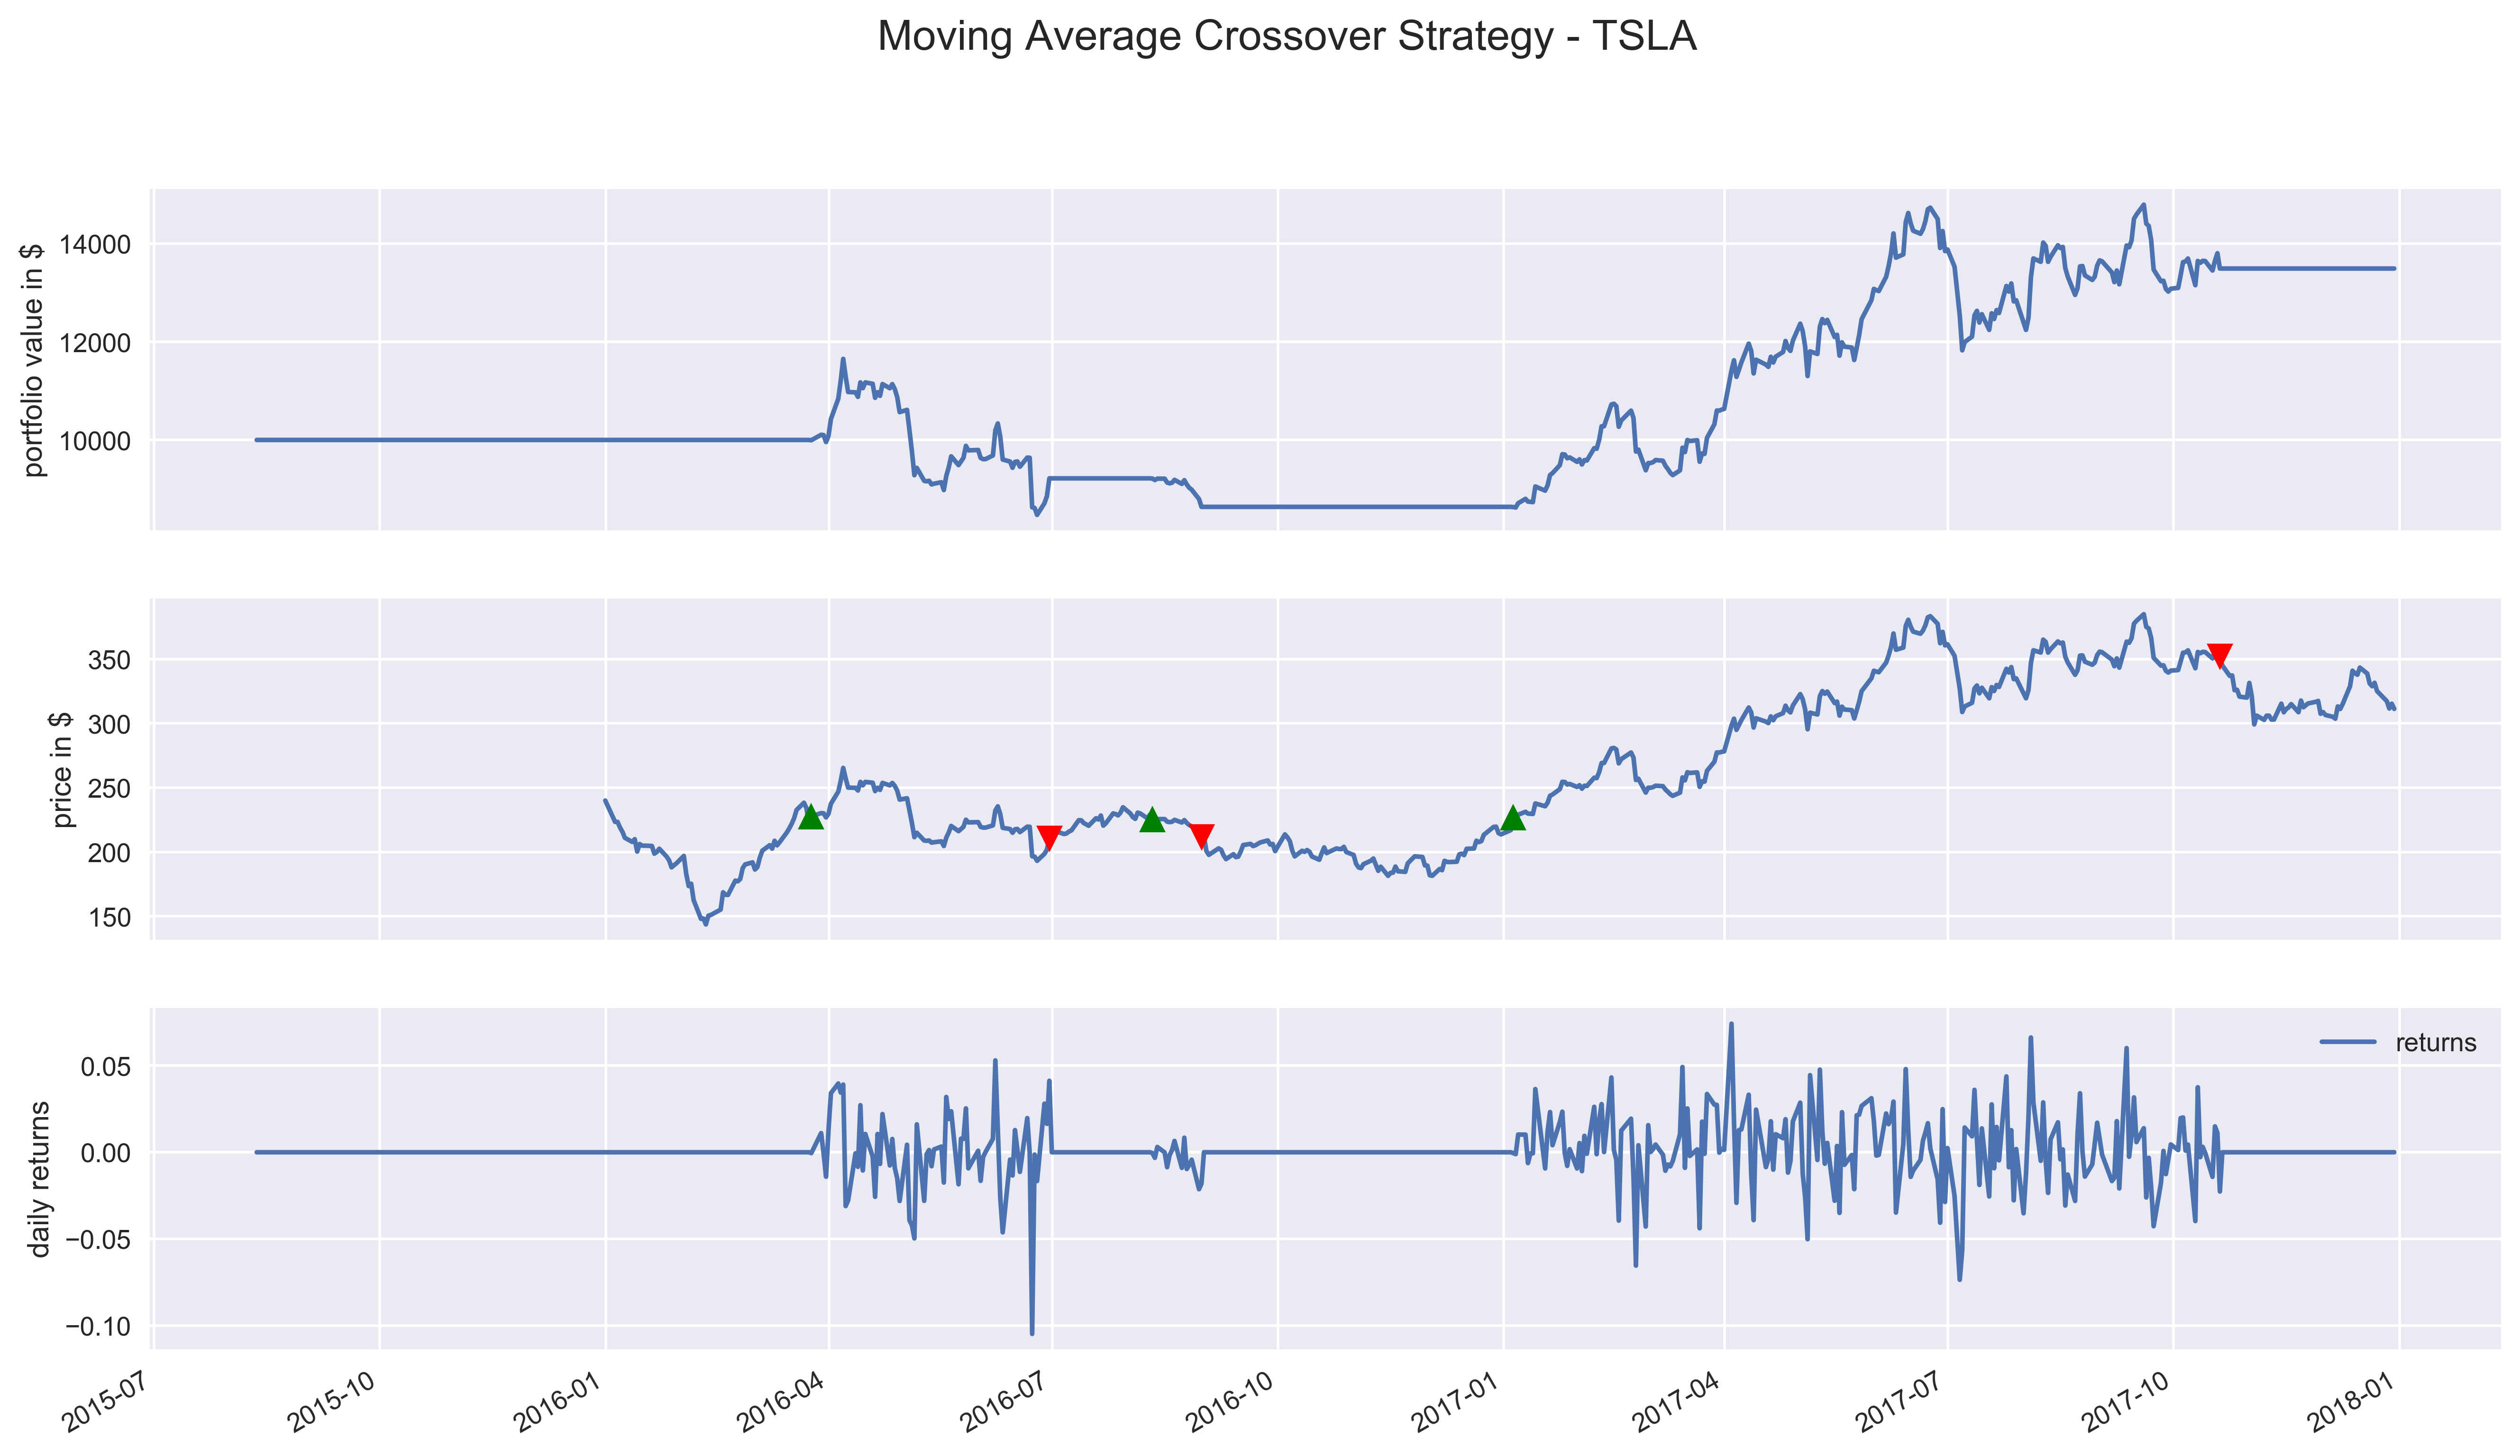

Final portfolio value (including cash): 13493.28$


In [28]:
visualize_results(mac_results, 'Moving Average Crossover Strategy - TSLA')

Below we plotted the two moving averages on top of the price series. We see that the strategy generated much fewer signals than the one based on SMA.

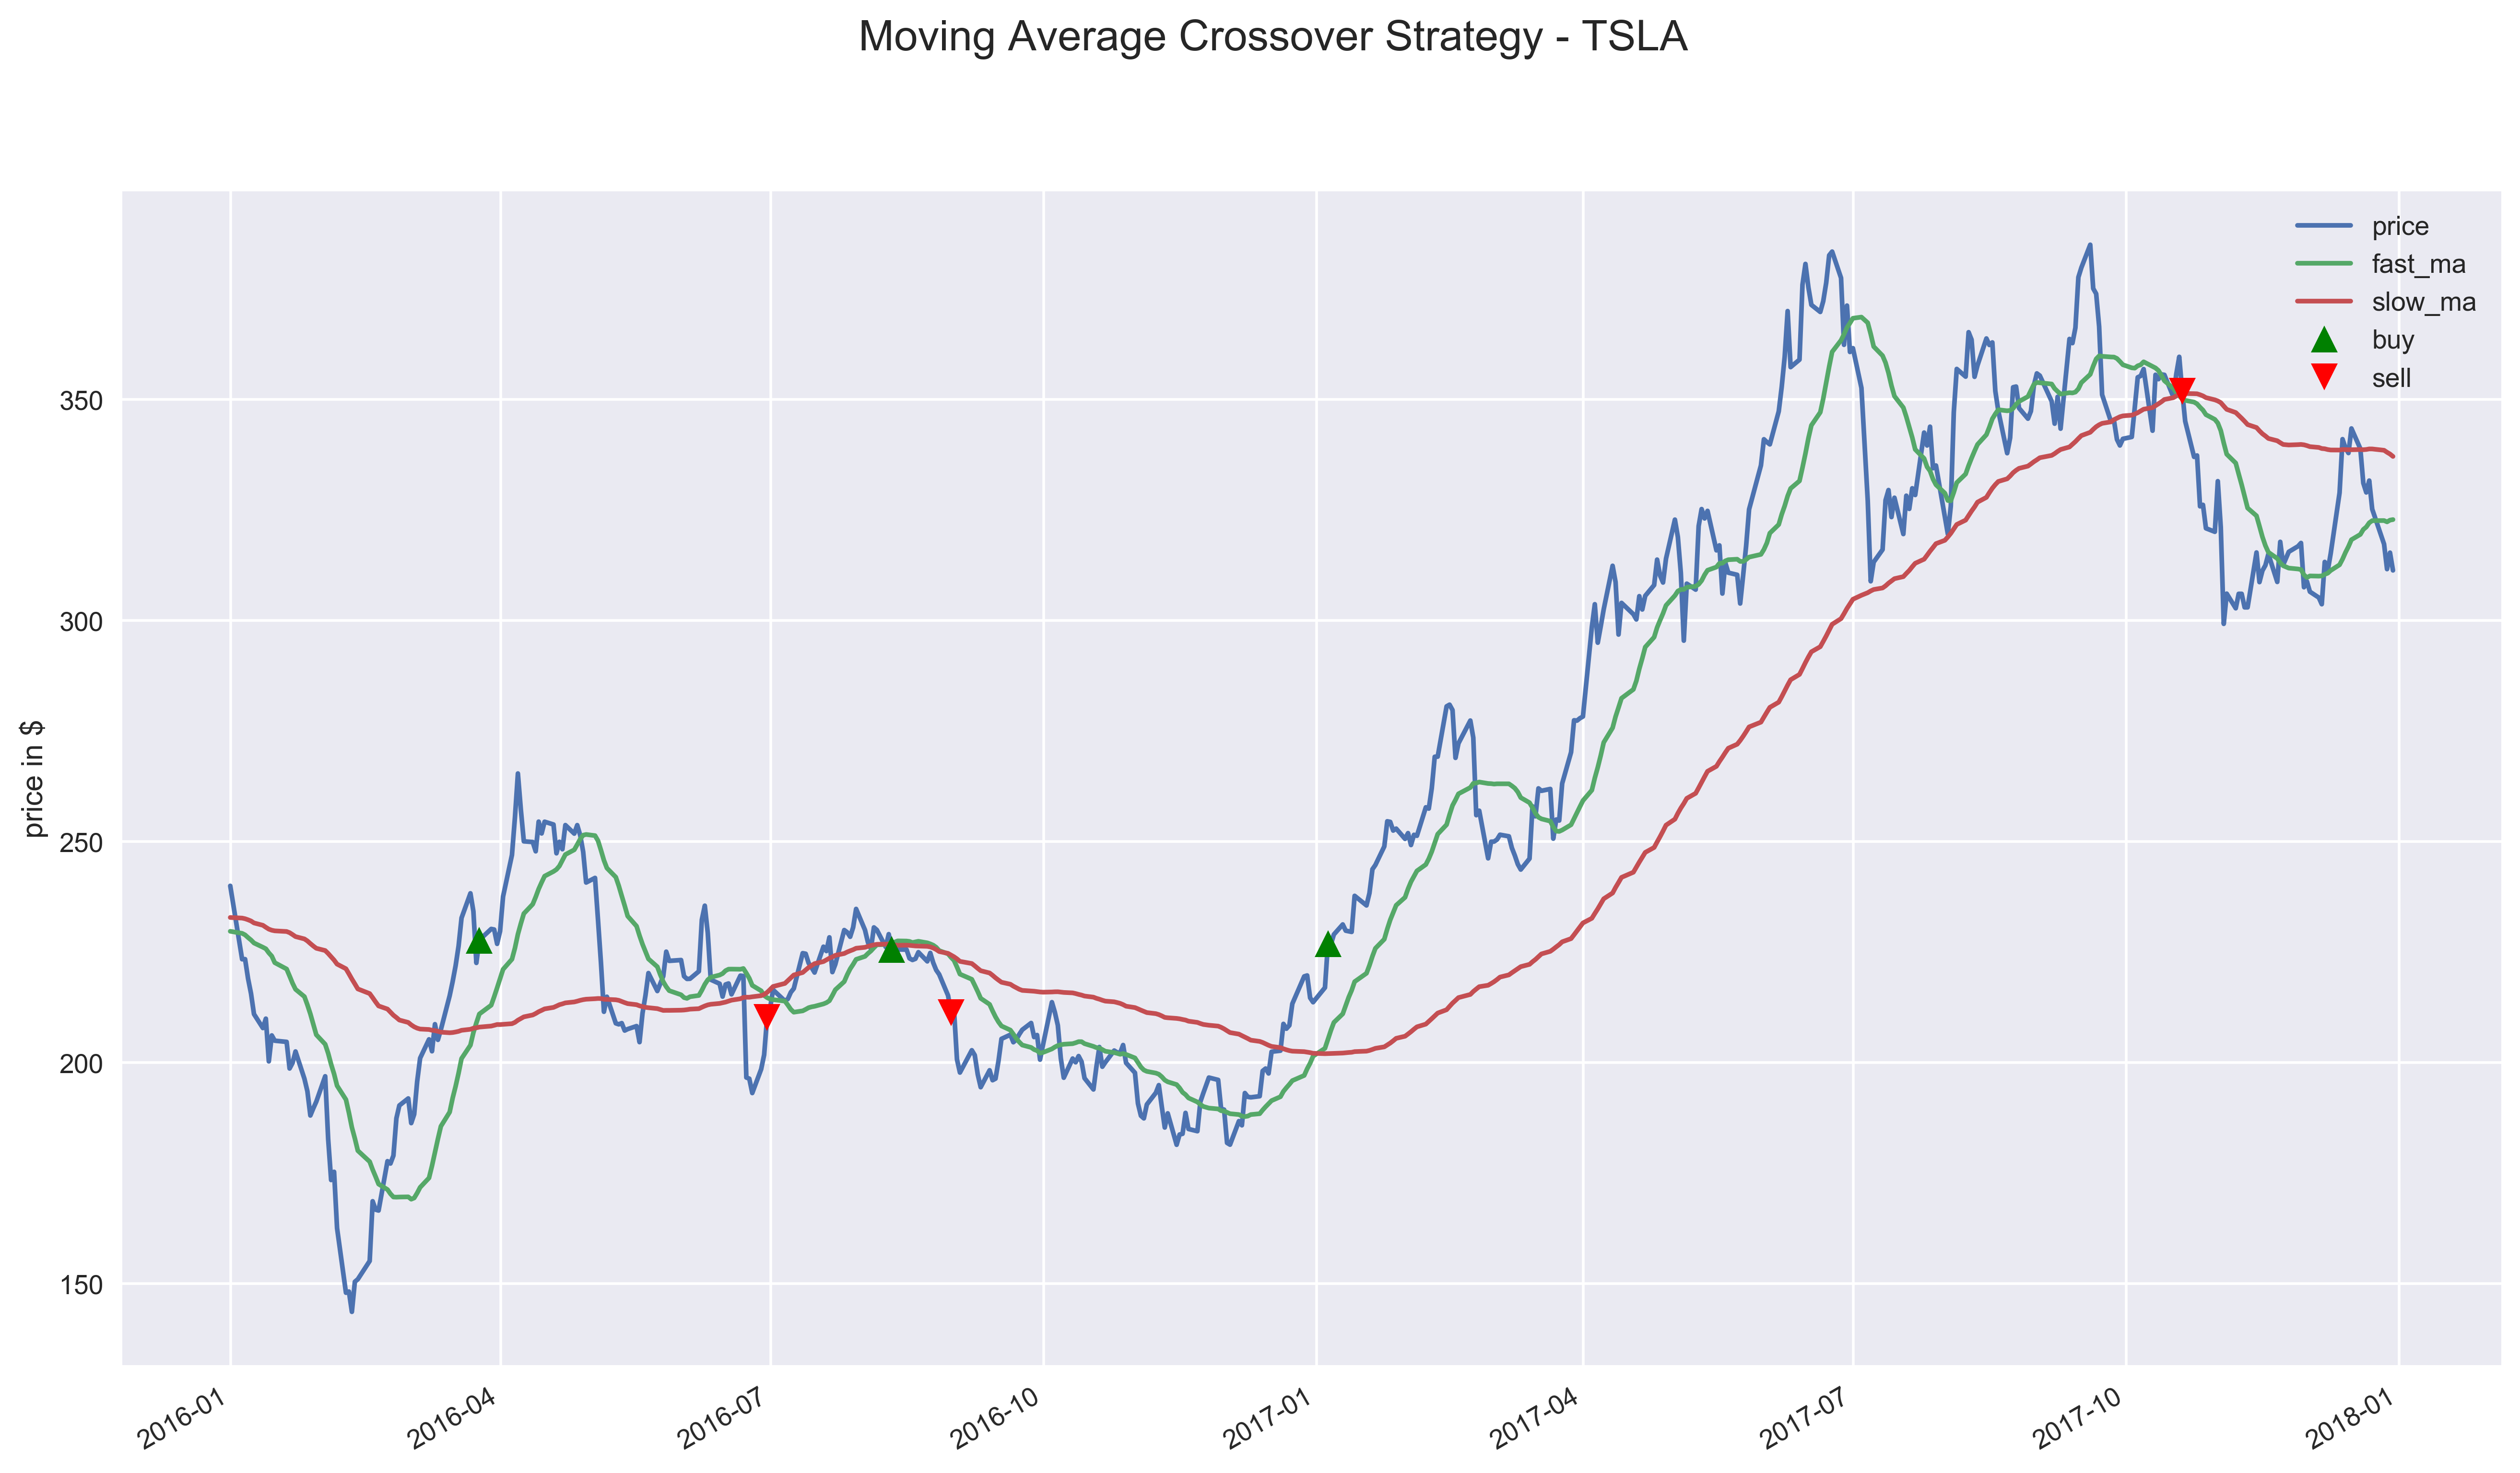

In [32]:
fig, ax = plt.subplots()

# asset
mac_results[['price', 'fast_ma', 'slow_ma']].plot(ax=ax)
ax.set_ylabel('price in $')

# mark transactions
perf_trans = mac_results.loc[[t != [] for t in mac_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, mac_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, mac_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('Moving Average Crossover Strategy - TSLA', fontsize=16)
plt.legend()
plt.show()

In [33]:
mac_returns = mac_results.loc[mac_results.index >= '2016-01-04', 'returns']

In [34]:
mac_perf = get_performance_summary(mac_returns)

### MACD

MACD stands for Moving Average Convergence/Divergence and is an indicator/oscillator used in technical analysis of stock prices.

MACD is a collection of three time series calculated using historical close prices:
* the MACD series - the difference between the fast (shorter period) and slow (longer period) exponential moving averages
* the signal - EMA on the MACD series
* the divergence - the difference between the MACD series and the signal

MACD is parametrized by the number of days used to calculate the three moving averages - MACD(a,b,c). a, corresponds to the fast EMA, b to the slow EMA, and c to the MACD signal EMA. The most common setup, also used in this article, is MACD(12,26,9). Historically, these numbers corresponded to 2 weeks, 1 month and 1.5 weeks based on a 6-day working week.

One thing to remember is that MACD is a lagging indicator, as it is based on moving averages. That is why the MACD is less useful for stocks that do not exhibit a trend or are trading with erratic price action.

The strategy we use in this article can be described by:
* buy shares when the MACD crosses the signal line upwards
* sell shares when the MACD crosses the signal line downwards

As before, to counter the warm-up period we need to ascertain that we have 34 observations to calculate the MACD.

In [35]:
get_start_date('TSLA', '2016-01-04', 34)

'2015-11-12'

In [36]:
%%zipline --start 2015-11-12 --end 2017-12-31 --capital-base 10000.0 -o macd.pkl

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'TSLA'

 #initialize the strategy 
def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    context.time += 1
    if context.time < 34:
        return
    
    price_history = data.history(context.asset, fields="price", bar_count=34, frequency="1d")
    macd, macdsignal, macdhist = ta.MACD(price_history, 12, 26, 9) 
    
    if (macdsignal[-1] < macd[-1]) and (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
        
    if (macdsignal[-1] > macd[-1]) and (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False
        
    record(macd =  macd[-1], macdsignal = macdsignal[-1], macdhist = macdhist[-1], price=price_history[-1]) 

/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


algo_volatility  algorithm_period_return     alpha  \
2015-11-12 21:00:00+00:00              NaN                 0.000000       NaN   
2015-11-13 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-16 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-17 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-18 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-19 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-20 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-23 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-24 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-25 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-27 18:00:00+00:00         0.000000                 0.000000  0.000000   
2015-11-30 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-01 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-02 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-03 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-04 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-07 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-08 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-09 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-10 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-11 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-14 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-15 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-16 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-17 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-18 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-21 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-22 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-23 21:00:00+00:00         0.000000                 0.000000  0.000000   
2015-12-24 18:00:00+00:00         0.000000                 0.000000  0.000000   
...                                    ...                      ...       ...   
2017-11-16 21:00:00+00:00         0.223418                 0.587914  0.217303   
2017-11-17 21:00:00+00:00         0.223255                 0.600919  0.221524   
2017-11-20 21:00:00+00:00         0.223529                 0.568738  0.211009   
2017-11-21 21:00:00+00:00         0.224206                 0.614995  0.223361   
2017-11-22 21:00:00+00:00         0.224322                 0.588424  0.214863   
2017-11-24 18:00:00+00:00         0.224181                 0.603469  0.218659   
2017-11-27 21:00:00+00:00         0.223973                 0.609895  0.220293   
2017-11-28 21:00:00+00:00         0.223756                 0.613669  0.219475   
2017-11-29 21:00:00+00:00         0.224702                 0.562618  0.203529   
2017-11-30 21:00:00+00:00         0.224496                 0.569299  0.203796   
2017-12-01 21:00:00+00:00         0.224357                 0.557467  0.199971   
2017-12-04 21:00:00+00:00         0.224171                 0.550684  0.197625   
2017-12-05 21:00:00+00:00         0.223992                 0.543034  0.195340   
2017-12-06 21:00:00+00:00         0.224791                 0.591790  0.210260   
2017-12-07 21:00:00+00:00         0.224635                 0.581488  0.206338   
2017-12-08 21:00:00+00:00         0.224563                 0.601327  0.210885   
2017-12-11 21:00:00+00:00         0.226311                 0.671605  0.230589   
2017-12-12 21:00:00+00:00         0.227459                

In [37]:
macd_results = pd.read_pickle('macd.pkl')

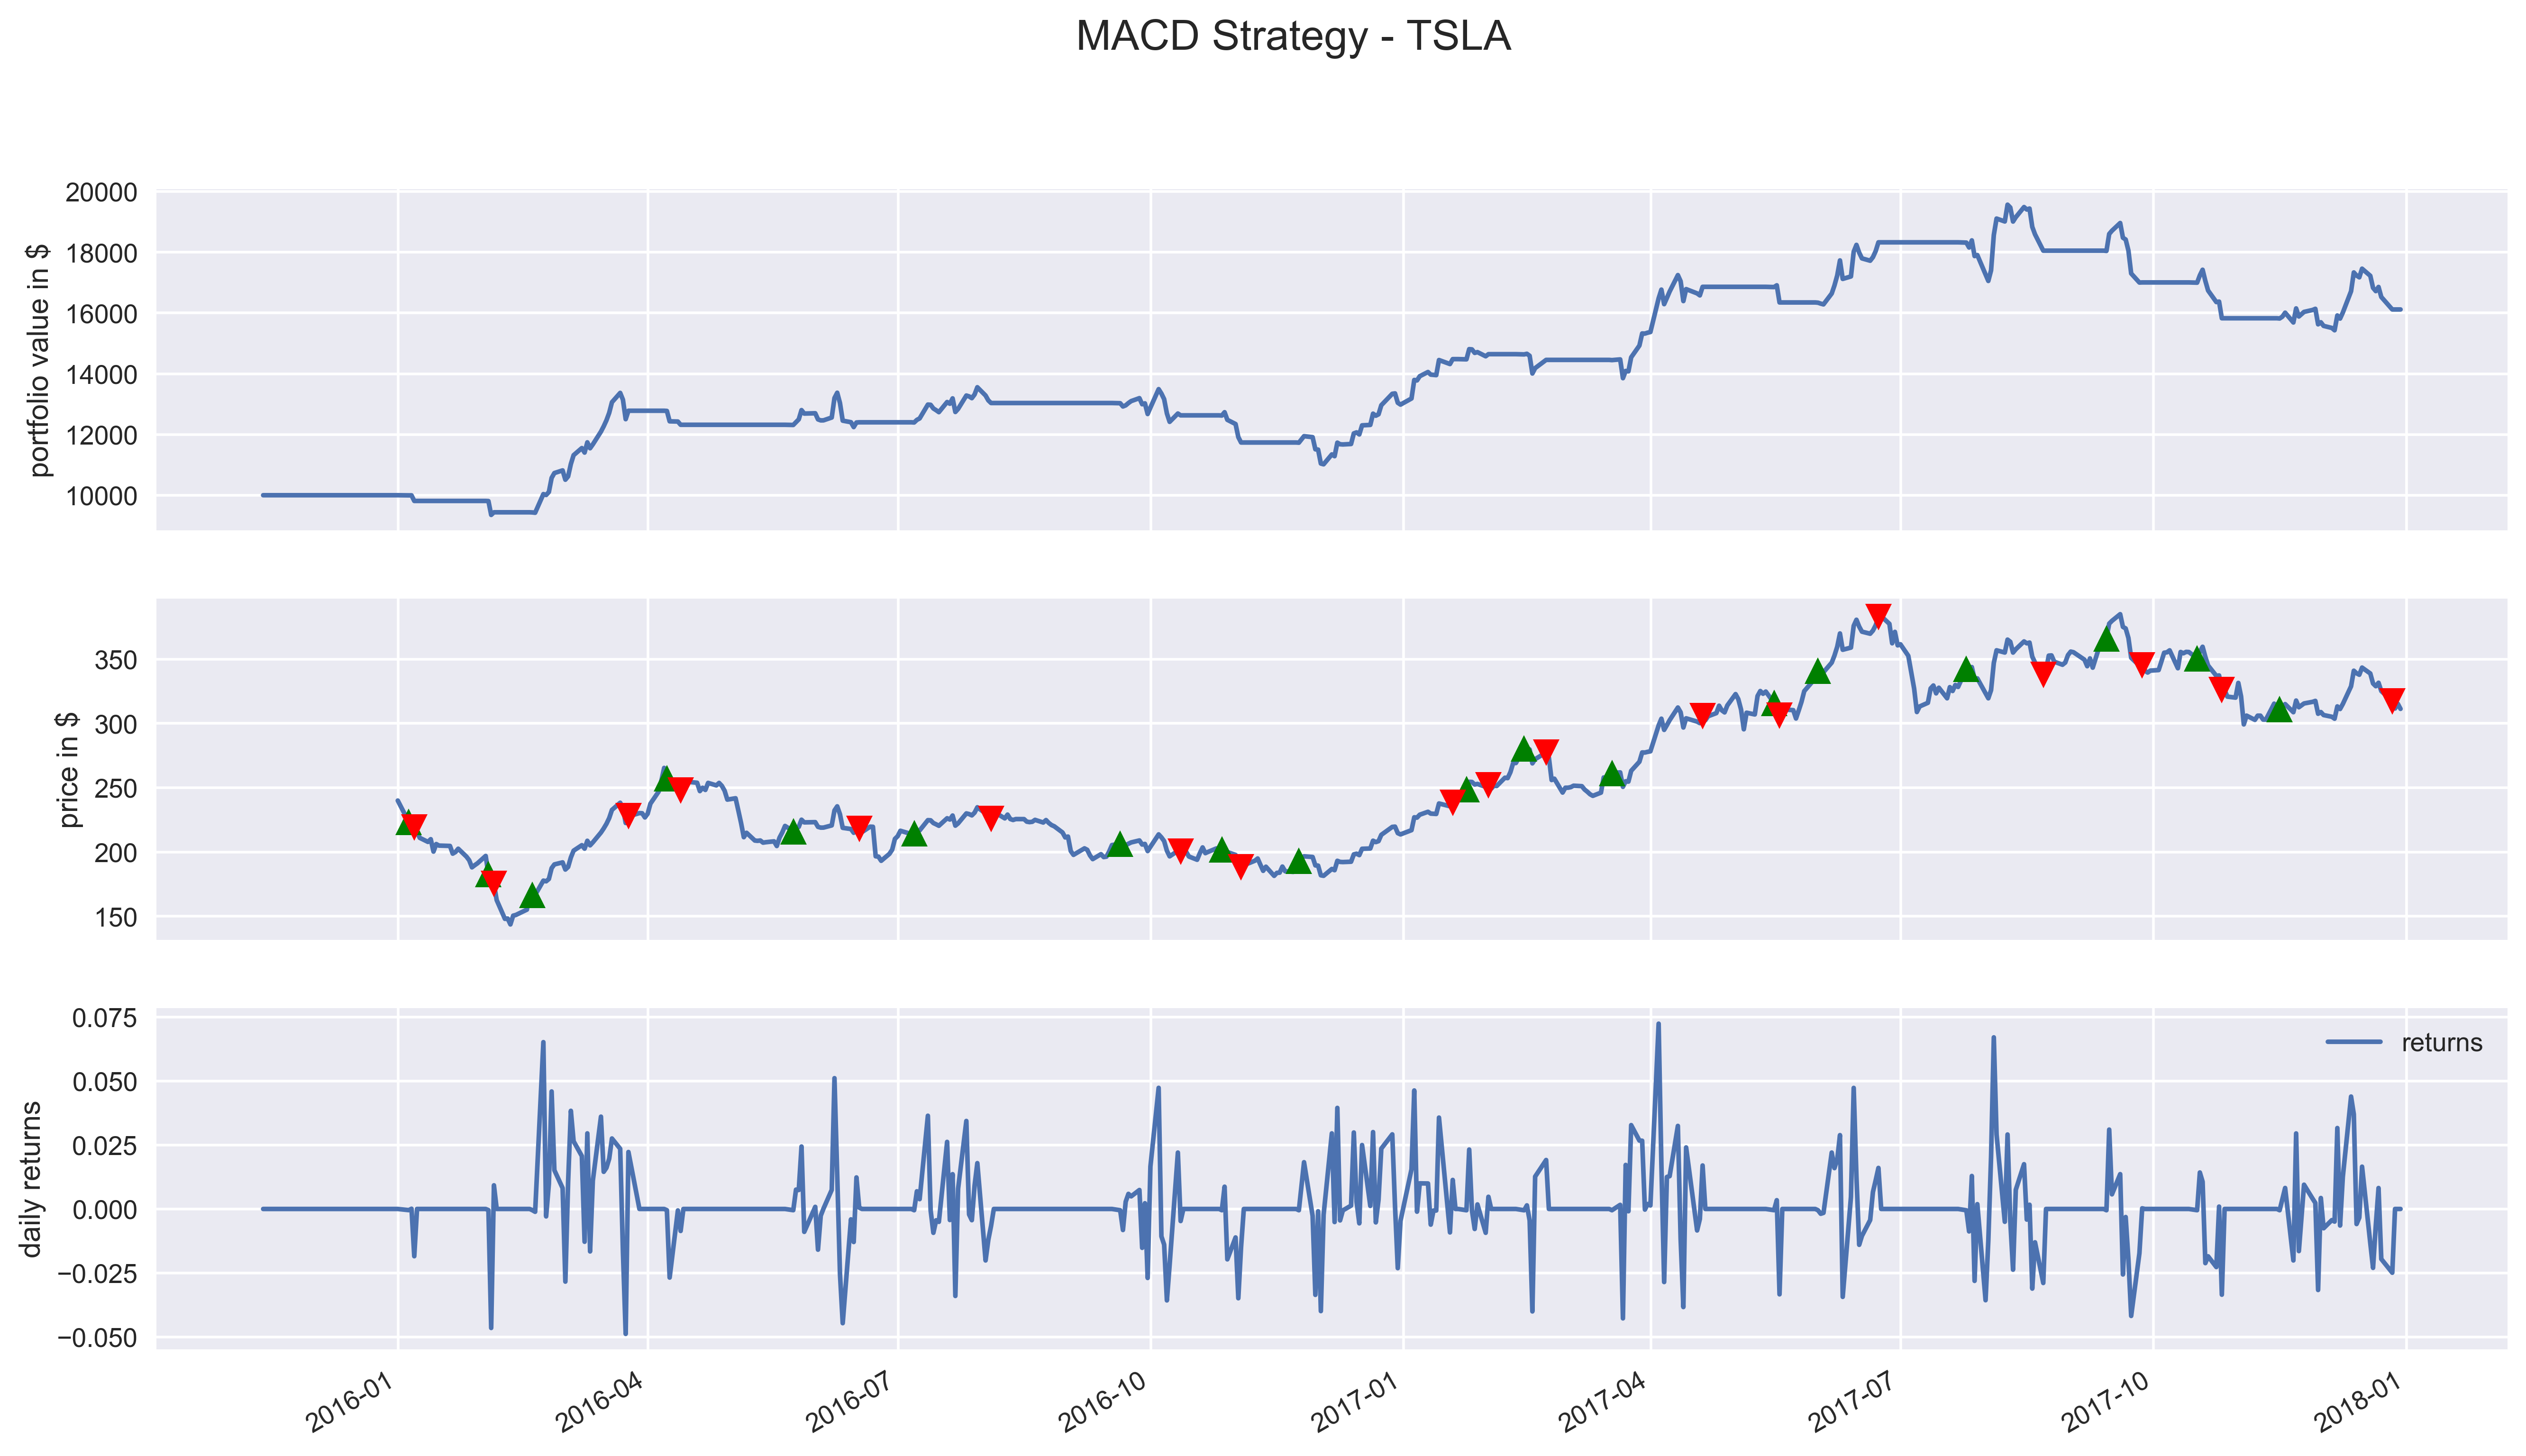

Final portfolio value (including cash): 16115.34$


In [40]:
visualize_results(macd_results, 'MACD Strategy - TSLA')

Below we plot the MACD and the signal lines, where the crossovers indicate buy/sell signals. Additionally, one could plot the MACD divergence in the form of a barplot (it is commonly referred to as the MACD histogram).

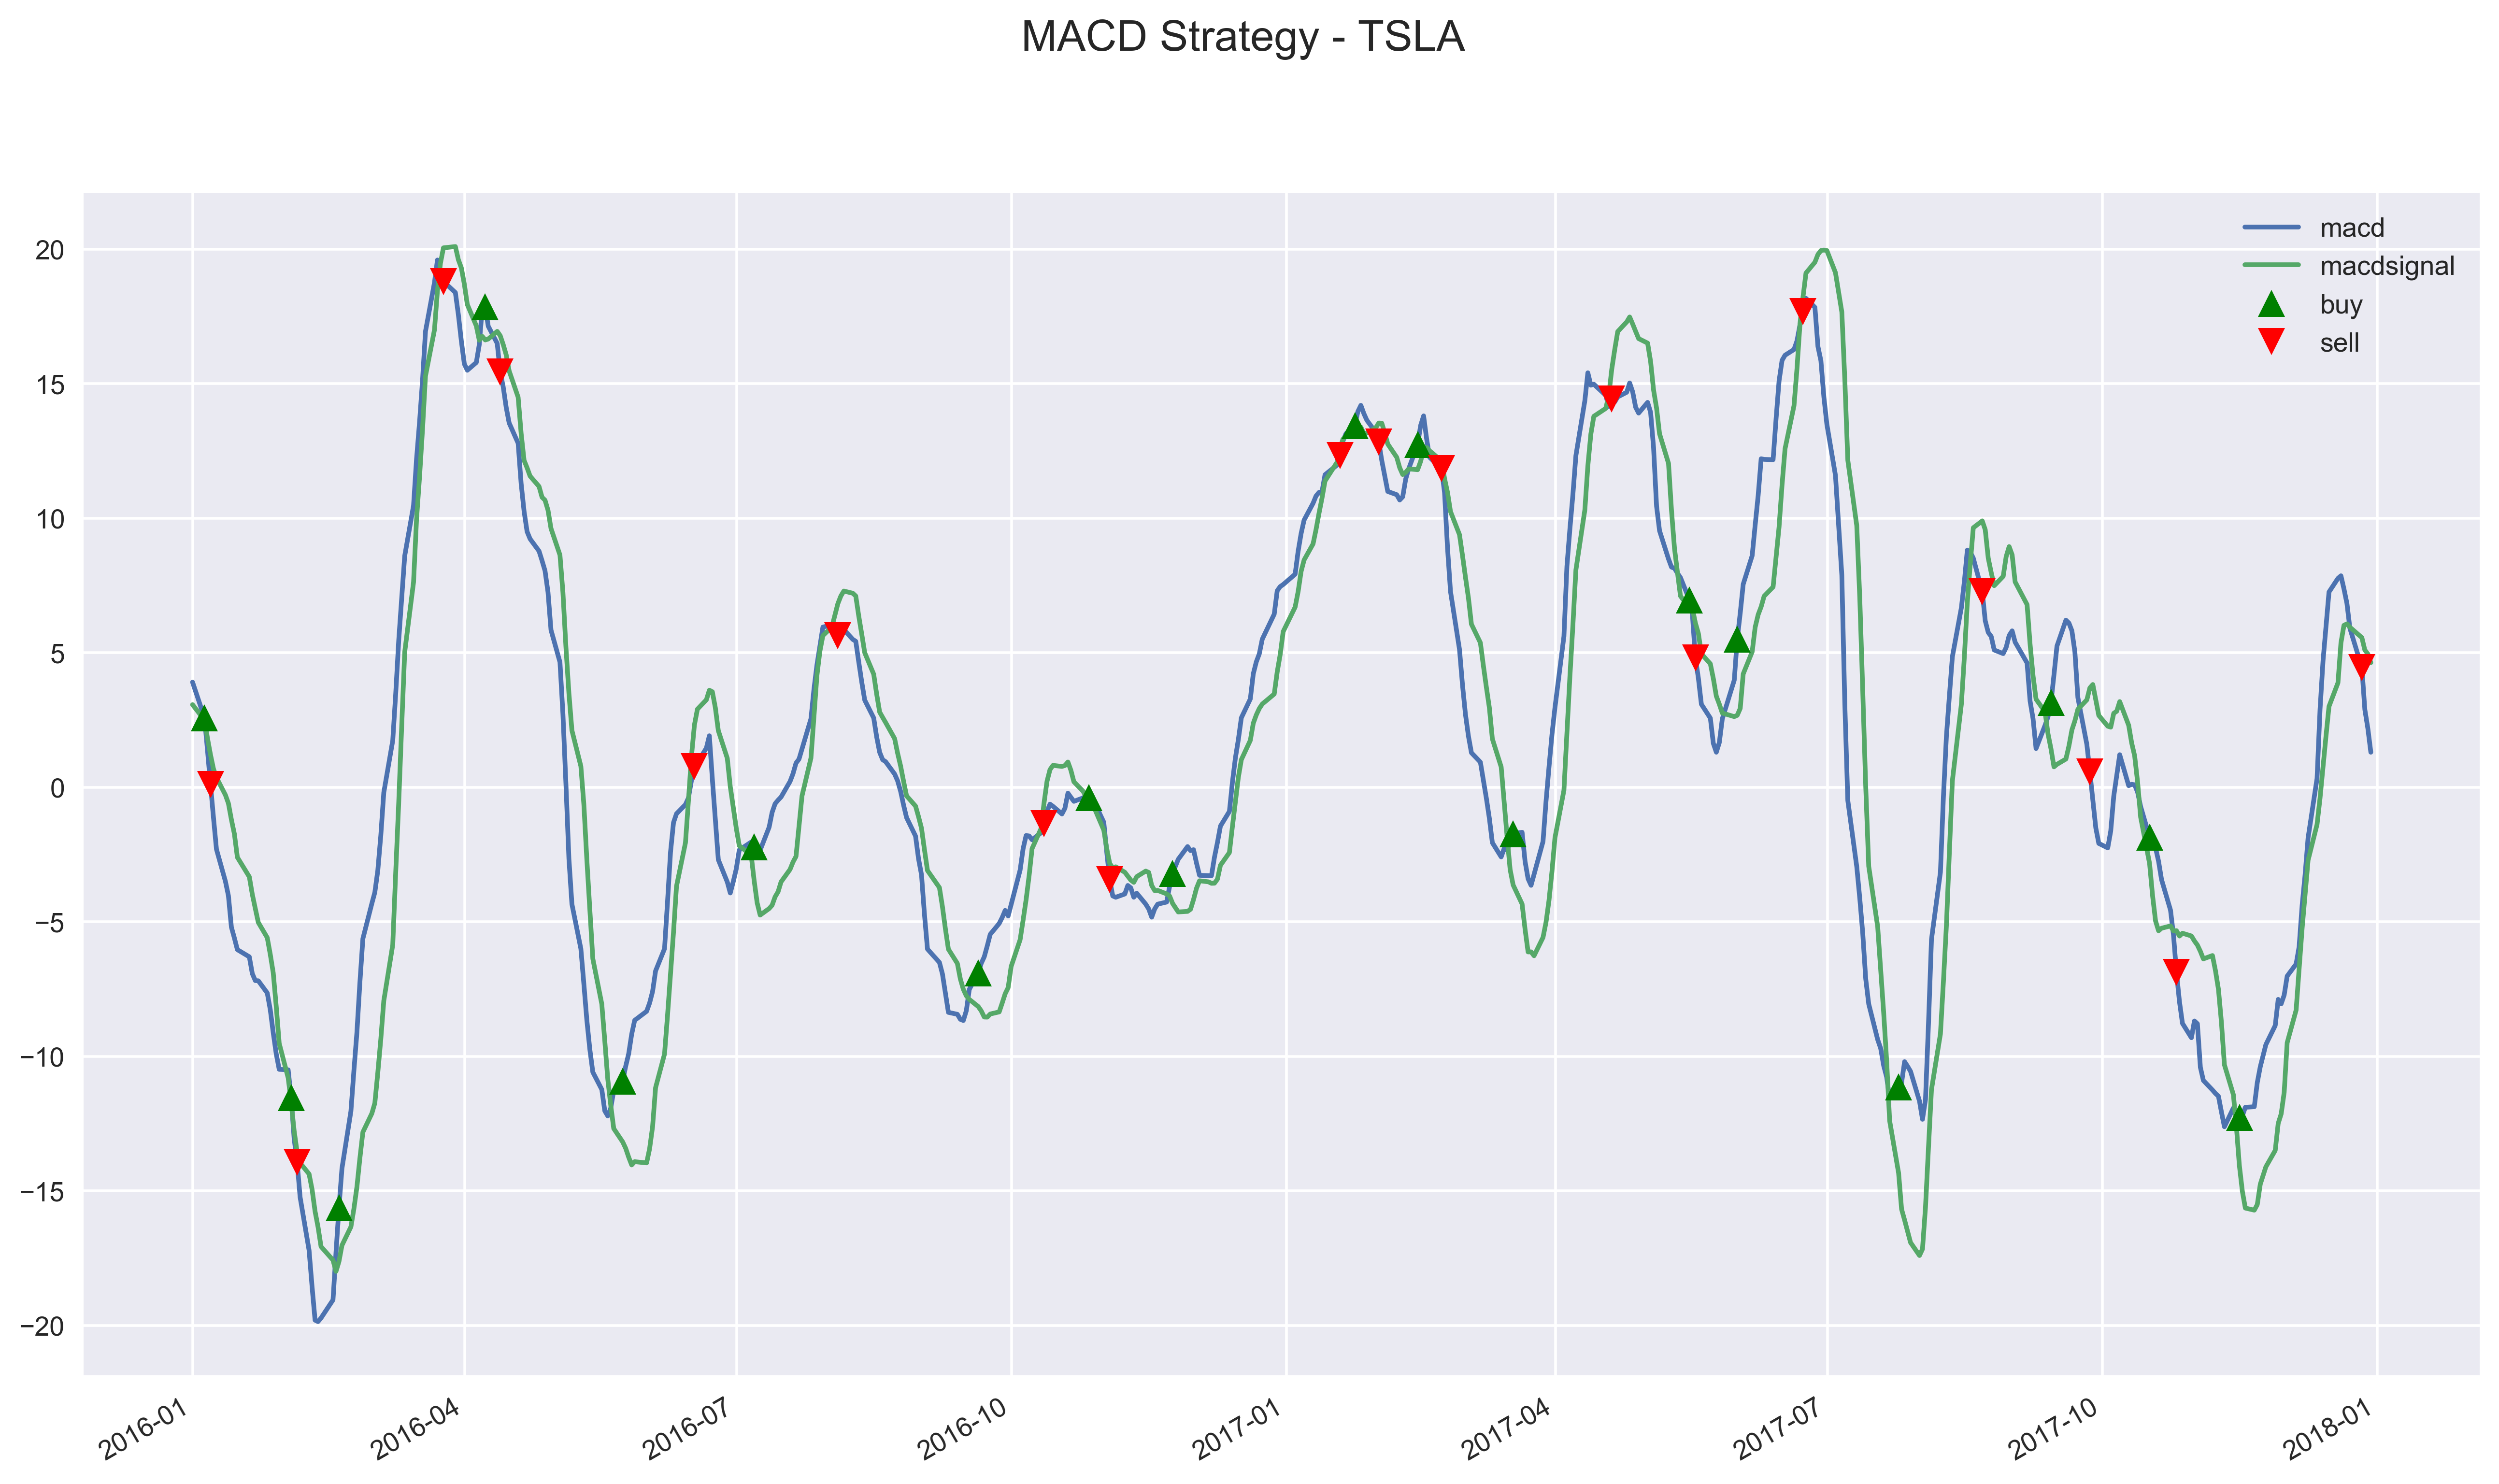

In [41]:
fig, ax = plt.subplots()

# asset
macd_results[['macd', 'macdsignal']].plot(ax=ax)

# mark transactions
perf_trans = macd_results.loc[[t != [] for t in macd_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, macd_results.macd.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, macd_results.macd.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('MACD Strategy - TSLA', fontsize=16)
plt.show()

In [42]:
macd_returns = macd_results.loc[macd_results.index >= '2016-01-04', 'returns']

In [43]:
macd_perf = get_performance_summary(macd_returns)

### RSI 

RSI stands for the Relative Strength Index, which is another technical indicator we can use to create trading strategies. The RSI is classified as a momentum oscillator and it measures the velocity and magnitude of directional price movements. Momentum describes the rate at which the price of the asset rises or falls.

Without going into too many technical details, the RSI measures momentum as the ratio of higher closes to lower closes. Assets with more/stronger positive changes have higher RSI than assets with more/stronger negative changes.

The output of the RSI is a number on a scale from 0 to 100 and it is typically calculated on a 14-day basis. To generate the trading signals, it is common to specify the low and high levels of the RSI at 30 and 70, respectively. The interpretation of the thresholds is that the lower one indicates that the asset is oversold, and the upper one that the asset is overbought.

Sometimes, a medium level (halfway between low and high) is also specified, for example in case of strategies which also allow for short-selling. We can also select more extreme thresholds such as 20 and 80, which would then indicate stronger momentum. However, this should be specified using domain knowledge or by running backtests.

The strategy we consider can be described as:
* when the RSI crosses the lower threshold (30) - buy 
* when the RSI crosses the upper threshold (70) - sell

In [ ]:
get_start_date('TSLA', '2016-01-04', 15)

In [ ]:
%%zipline --start 2015-12-10 --end 2017-12-31 --capital-base 10000.0 -o rsi.pkl

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'TSLA'
UPPER = 70
LOWER = 30
RSI_PERIOD = 14

 #initialize the strategy 
def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    context.time += 1
    if context.time < RSI_PERIOD + 1:
        return
    
    price_history = data.history(context.asset, fields="price", bar_count=RSI_PERIOD+1, frequency="1d")
    rsi = ta.RSI(price_history, timeperiod=RSI_PERIOD)
    
    if rsi[-1] < LOWER and not context.has_position:
        order_percent(context.asset, 1.0)
        context.has_position = True
      
    if rsi[-1] > UPPER and context.has_position:
        order_target(context.asset, 0)
        context.has_position = False
     
    record(rsi=rsi[-1], price=price_history[-1], time=context.time) 

In [44]:
rsi_results = pd.read_pickle('rsi.pkl')

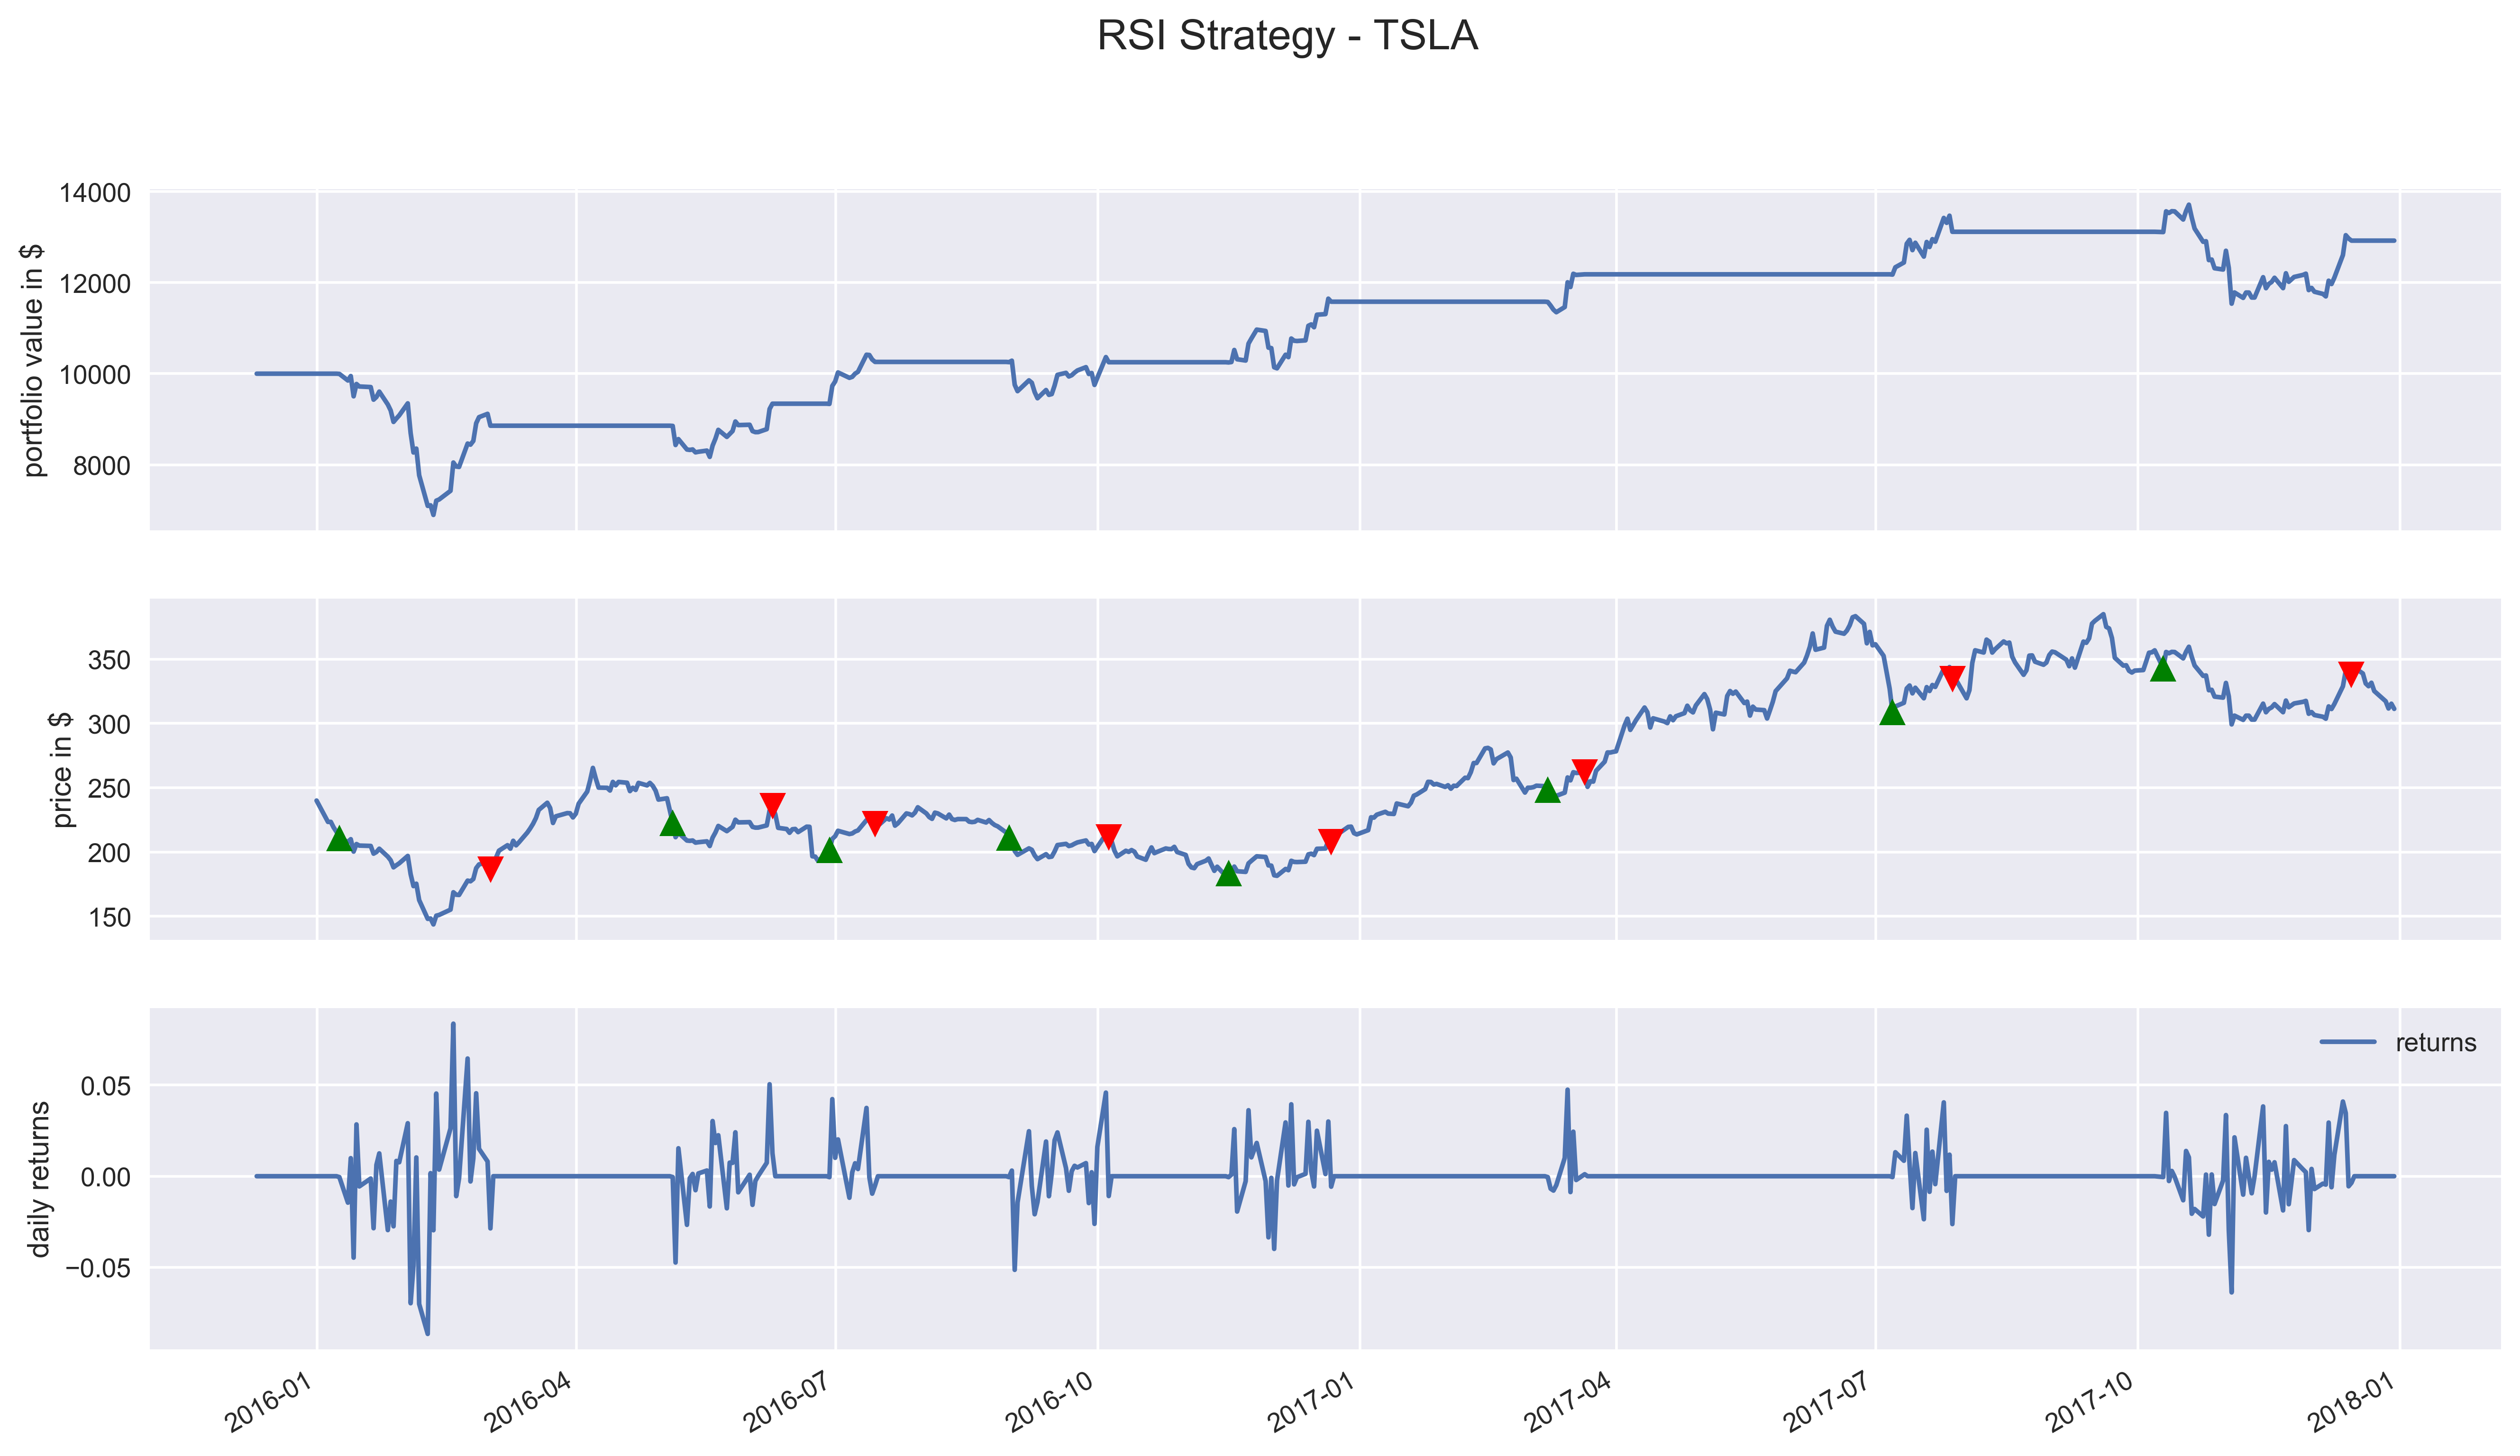

Final portfolio value (including cash): 12922.61$


In [45]:
visualize_results(rsi_results, 'RSI Strategy - TSLA')

Below we plot the RSI together with the upper and lower threshold.

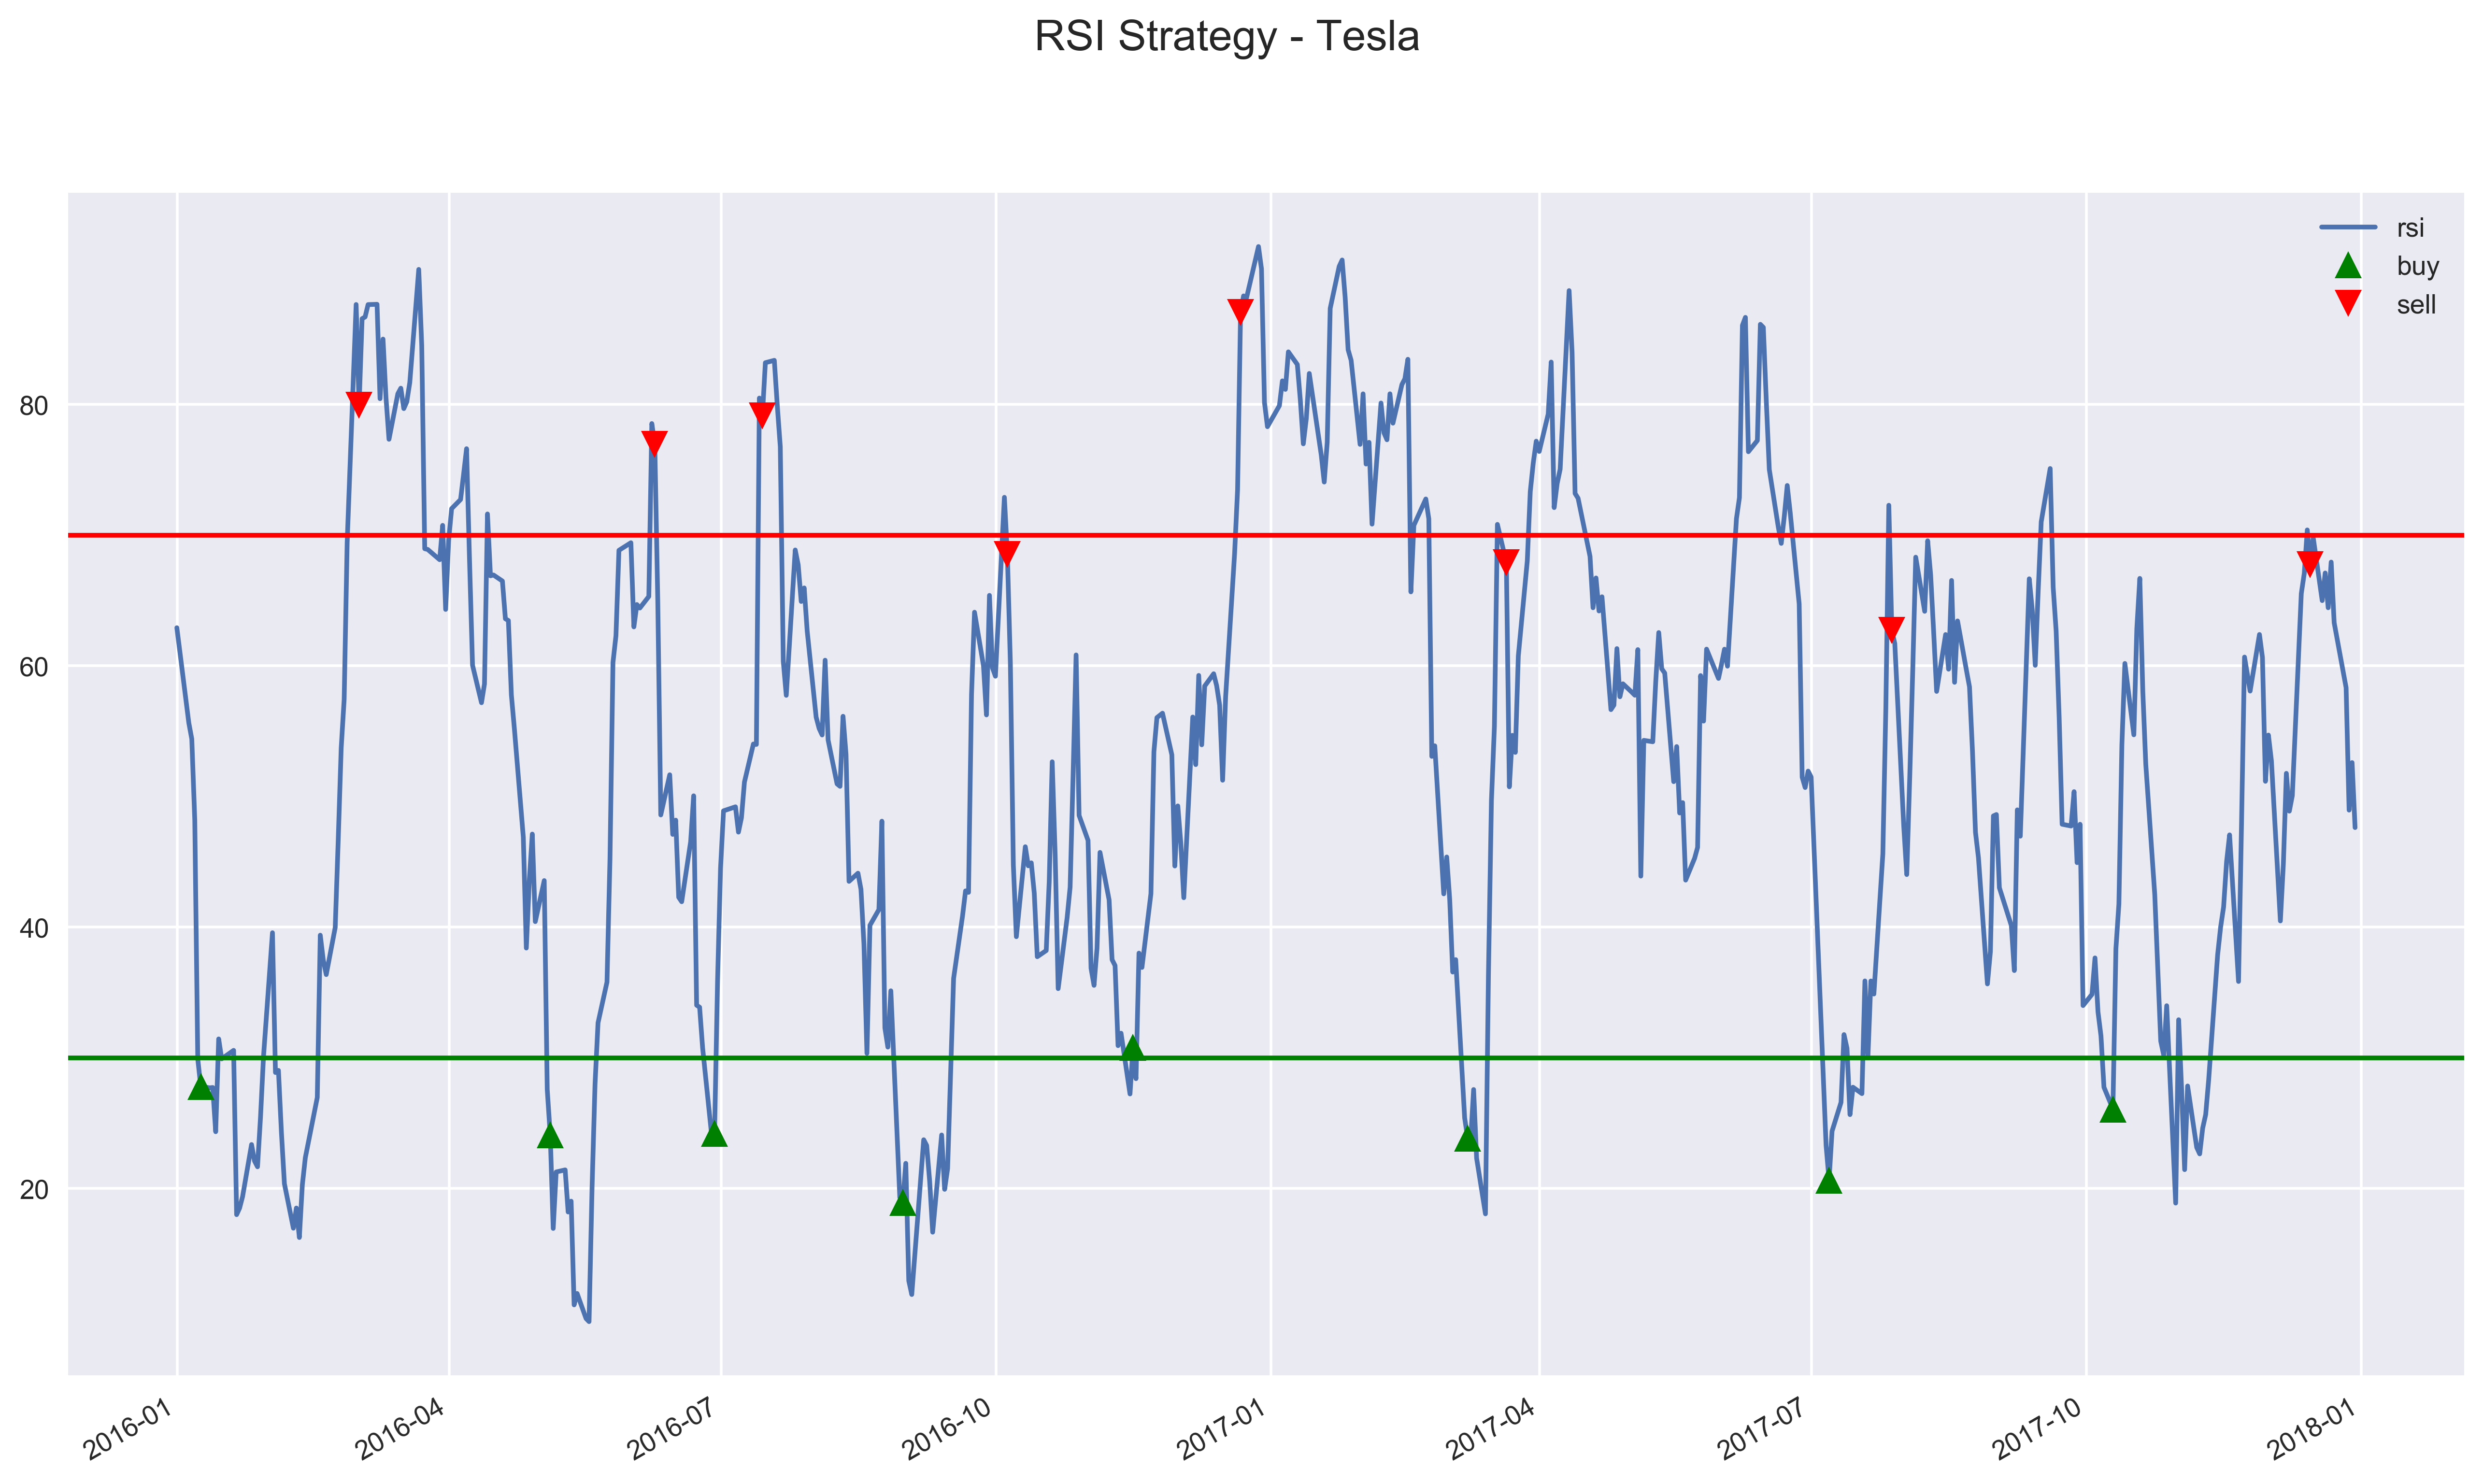

In [46]:
#fig, ax = plt.subplots(1, 1, sharex=True, figsize=[16, 9])
fig, ax = plt.subplots()

# asset
rsi_results[['rsi']].plot(ax=ax)
ax.axhline(y=70, color='r')
ax.axhline(y=30, color='g')

# mark transactions
perf_trans = rsi_results.loc[[t != [] for t in rsi_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, rsi_results.rsi.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, rsi_results.rsi.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('RSI Strategy - Tesla', fontsize=16)
plt.show()

In [47]:
rsi_returns = rsi_results.loc[rsi_results.index >= '2016-01-04', 'returns']

In [48]:
rsi_perf = get_performance_summary(rsi_returns)

## Evaluating the performance

The last step involves putting all the performance metrics into one DataFrame and inspecting the results. We can see that in the case of our backtest, the strategy based on the simple moving average performed best in terms of generated returns. It also had the highest Sharpe ratio - the highest excess return (in this case return, as we do not consider a risk-free asset) per unit of risk. The second-best strategy turned out to be the one based on the MACD. It is also good to notice that only these two performed better than the benchmark buy and hold strategy.

In [49]:
perf_df = pd.DataFrame({'Buy and Hold': buy_and_hold_perf,
                        'Simple Moving Average': sma_perf,
                        'Moving Average Crossover': mac_perf,
                        'MACD': macd_perf,
                        'RSI': rsi_perf})
perf_df.transpose()

annual_volatility  annualized_returns  \
Buy and Hold                       0.361997            0.177819   
MACD                               0.234827            0.270064   
Moving Average Crossover           0.272147            0.161952   
RSI                                0.230923            0.137067   
Simple Moving Average              0.243737            0.282103   

                          cumulative_returns  max_drawdown  sharpe_ratio  \
Buy and Hold                        0.386356     -0.351436      0.633844   
MACD                                0.611534     -0.211331      1.135038   
Moving Average Crossover            0.349328     -0.272893      0.688228   
RSI                                 0.292261     -0.310203      0.671949   
Simple Moving Average               0.642167     -0.285880      1.141387   

                          sortino_ratio  
Buy and Hold                   0.894941  
MACD                           1.803431  
Moving Average Crossover       0.980659  
RSI                            0.977968  
Simple Moving Average          1.756770

## Conclusions

In this short article I showed how to combine `zipline` with `talib` in order to backtest trading strategies based on popular technical indicators such as moving averages, the MACD, the RSI, etc. But this was only the beginning, as it is possible to create much more sophisticated strategies. Some of the possible future directions:
* include multiple assets into the strategies
* allow for short-selling 
* mix the indicators
* backtest different parameters for each strategy to find the best-performing ones

We must also remember that the fact that the strategy performed well in the past is no guarantee that this will happen again in the future.

As always, any constructive feedback is welcome. You can reach out to me on Twitter or in the comments.